## Проект по улучшению модели прогнозирования недвижимости на сайте агрегатора

Описание проекта:

Мы работаем в Яндекс Недвижимости, маркетплейсе для аренды и покупки жилой и коммерческой недвижимости. Наша задача — выступить надёжным посредником между арендодателями или продавцами и потенциальными арендаторами или покупателями, сделав процесс сделки максимально эффективным и безопасным для обеих сторон.

Стоимость объекта недвижимости можно объективно оценить извне — это устранит разногласия между сторонами и увеличит среднемесячное количество сделок на платформе.

 Мы разработали базовое решение в виде модели машинного обучения, а также организовали пайплайн данных в Airflow + DVC. Менеджеры убедились, что модель с точки зрения бизнеса потенциально прибыльна, однако вместе с тем сделали вывод, что метрики модели можно улучшить. Этим в этом проекте мы и займемся.

**Важные замечания к проекту:**

* В этап с DVC добавил логирование в Mlflow
* В качестве целевой метрики буду рассчитывать r2_score
* На этапе feature selection ограничил сложность алгоритмов отбора для ускорения вычисления и уменьшении времени работы ВM
* Прологарифмировал таргет, в конце его не переводил обратно специально, чтобы работать с метриками было удобнее. В дальнейшем предполагается в реальном жизненом цикле встроить обратное преобразование и вернуть таргет к своим единицам измерения


### Этап 1 - Настройка 

#### 1.1 Загрузка библиотек и настройка подключений

In [1]:
! pip install phik geopy

In [2]:
import json
import os
from typing import Dict, Any, List
import warnings

import mlflow
import psycopg2 as psycopg
import optuna

import numpy as np
import pandas as pd
from scipy.stats import ks_2samp

import seaborn as sns
from matplotlib import pyplot as plt

from dotenv import load_dotenv
from geopy.distance import geodesic
from phik import phik_matrix
from phik.report import plot_correlation_matrix
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.compose import ColumnTransformer
from sklearn.metrics import mean_absolute_error, r2_score
from sklearn.model_selection import (KFold, RandomizedSearchCV, 
                                     cross_validate, train_test_split)
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import (KBinsDiscretizer, OneHotEncoder,
                                   PolynomialFeatures, SplineTransformer,
                                   StandardScaler)
from sklearn.tree import DecisionTreeRegressor

from mlxtend.feature_selection import SequentialFeatureSelector
from mlxtend.plotting import plot_sequential_feature_selection as plot_sfs
from autofeat import AutoFeatRegressor
from category_encoders import CatBoostEncoder
from optuna.integration import MLflowCallback

# настройка отображения таблиц pandas
pd.options.display.max_columns = 70
warnings.filterwarnings("ignore")



# настройки отображения и стилей графиков
plt.style.use('fivethirtyeight')
plt.rcParams['axes.titlesize'] = 12
plt.rcParams['axes.labelsize'] = 12

# адрес для подключения mlflow
TRACKING_SERVER_HOST = "127.0.0.1"
TRACKING_SERVER_PORT = 5000

# имя эксперимента для логирования в mlflow
EXPERIMENT_NAME = "ALEXEY_PROJECT"
RUN_NAME_EDA = 'EDA'

# директории и файлы для логирования
ARTIFACT_DIR = "ARTIFACT_EDA"
DATA_DIR_PATH = '/home/mle-user/mle-pipeline-model-development/data'
CV_RESULTS_PATH = "/home/mle-user/mle-pipeline-model-development/cv_results"
notebook_path = "/home/mle-user/mle-pipeline-model-development/model_improvement/notebook.ipynb"
conclusion_path = "/home/mle-user/mle-pipeline-model-development/model_improvement/colclusion_EDA.md"

# локальная БД для сохранения запусков optuna
STUDY_DB_NAME = "sqlite:///local.study.db"
STUDY_NAME = "bulding_model_5"

RANDOM_STATE = 42
N_SPLITS = 3

POLY_DEGREE = 2
KBINS_N_BINS = 5
SPLINE_DEGREE = 3
SPLINE_K_NOTS = 3


AFC_FEATENG_STEPS = 2
AFC_MAX_GB = 2
AFC_TRANSFORMATION = ['1/', 'log', 'abs', 'sqrt']
AFC_N_JOBS = 1

MODEL_MAX_DEPTH = 10

FS_SBS_K_FEATURES = 10
FS_SFS_K_FEATURES = 10


In [3]:
mlflow.set_tracking_uri(f"http://{TRACKING_SERVER_HOST}:{TRACKING_SERVER_PORT}")
mlflow.set_registry_uri(f"http://{TRACKING_SERVER_HOST}:{TRACKING_SERVER_PORT}")

# инициализируем client API
client = mlflow.MlflowClient(tracking_uri=f"http://{TRACKING_SERVER_HOST}:{TRACKING_SERVER_PORT}",
                             registry_uri=f"http://{TRACKING_SERVER_HOST}:{TRACKING_SERVER_PORT}")

# получаем уникальный номер эксперимента по имени
experiment_id = client.get_experiment_by_name(EXPERIMENT_NAME).experiment_id

# создание директории для артефактов
os.makedirs(ARTIFACT_DIR, exist_ok=True)

In [4]:
# Функция получения метрик на кросс-валидации и test

def calculate_rmse(predictions: np.ndarray, targets: np.ndarray) -> float:
    return np.sqrt(((predictions - targets) ** 2).mean())

def evaluate_model(model: BaseEstimator, train: np.ndarray,
                   target_train: np.ndarray, test: np.ndarray,
                   target_test: np.ndarray, cv_strategy: Any) -> Dict[str, float]:
    """Расчет метрик на кросс-валидации и test"""

    cv_res = cross_validate(
        model,
        train,
        target_train,
        cv=cv_strategy,
        n_jobs=3,
        scoring=['neg_root_mean_squared_error', 'r2', 'neg_mean_absolute_error']
    )

    # Переименовываем ключи
    cv_res_renamed = {f'cv_{key[5:]}': value for key, value in cv_res.items() if key.startswith('test_')}
    # Добавляем остальные ключи без изменений
    cv_res_renamed.update({key: value for key, value in cv_res.items() if not key.startswith('test_')})
    
    # Результаты с кросс-валидации
    for key, value in cv_res_renamed.items():
        if isinstance(value, list) or isinstance(value, np.ndarray):
            cv_res_renamed[key] = round(value.mean(), 3)
        else:
            cv_res_renamed[key] = round(value, 3)

    # Оцениваем модель на тестовом наборе данных
    predictions = model.predict(test)
    cv_res_renamed['test_rmse'] = round(calculate_rmse(predictions, target_test), 3)
    cv_res_renamed['test_r2'] = round(r2_score(target_test, predictions), 3)
    cv_res_renamed['test_mae'] = round(mean_absolute_error(target_test, predictions), 3)

    return cv_res_renamed



In [5]:
# Функция по добавлению оценки и имя модели в df

result_df = pd.DataFrame()

def append_result_to_df(results: Dict[str, float],
                        model_name: str,
                        df: pd.DataFrame) -> pd.DataFrame:
    """Добавляем результаты модели в таблицу"""

    results['model'] = model_name

    # преобразуем словарь в df
    results_df = pd.DataFrame([results])

    # Добавляем результаты в основной DataFrame
    df = pd.concat([df, results_df], ignore_index=True)
    
    print(f'Сравнительная таблица после добавления модели {model_name}')
    display(df)
    
    return df


In [6]:
# На этапе dvc в папке scripts лежат исходники, были залогированые метрики и модель в mlflow. Извлечь их из mlflow, чтобы 
# занести в таблицу для сравнения


result_baseline = client.get_run(run_id='6aee201f20bc4fceaa3a28066ac06a5d').data.params
result_baseline


{'cv_neg_root_mean_squared_error': '-0.257',
 'cv_r2': '0.508',
 'cv_neg_mean_absolute_error': '-0.199',
 'fit_time': '0.779',
 'score_time': '0.022',
 'test_rmse': '0.252',
 'test_r2': '0.335',
 'test_mae': '0.194'}

In [7]:
# Занесем эти данные в таблицу

result_df = append_result_to_df(result_baseline, "baseline_model", result_df)

Сравнительная таблица после добавления модели baseline_model


,cv_neg_root_mean_squared_error,cv_r2,cv_neg_mean_absolute_error,fit_time,score_time,test_rmse,test_r2,test_mae,model
0,-0.257,0.508,-0.199,0.779,0.022,0.252,0.335,0.194,baseline_model


#### 1.2. Извлекаем данные после этапа с Airflow


In [8]:
# Извлекаем данные после этапа с Airflow

load_dotenv()

connection = {"host": os.getenv("DB_DESTINATION_HOST"),
              'port': os.getenv("DB_DESTINATION_PORT"),
              "dbname": os.getenv("DB_DESTINATION_NAME"),
              "user": os.getenv("DB_DESTINATION_USER"),
              "password": os.getenv("DB_DESTINATION_PASSWORD"),
              'sslmode': 'require',
              'target_session_attrs': 'read-write'}

TABLE_NAME = 'clean_dataset_build_price_2'

with psycopg.connect(**connection) as conn:
    with conn.cursor() as cur:
        cur.execute(f'SELECT * FROM {TABLE_NAME}')
        data = cur.fetchall()
        columns = [col[0] for col in cur.description]

data = pd.DataFrame(data, columns=columns)


In [9]:
data

,id,id_build_flat,building_type_int,latitude,longitude,ceiling_height,flats_count,floors_total,has_elevator,floor,kitchen_area,living_area,rooms,is_apartment,total_area,price,build_year
0,1,6220_0,6,55.717113,37.781120,2.64,84,12,true,9,9.90,19.900000,1,false,35.099998,9500000.0,1965
1,2,18012_1,2,55.794849,37.608013,3.00,97,10,true,7,0.00,16.600000,1,false,43.000000,13500000.0,2001
2,3,17821_2,4,55.740040,37.761742,2.70,80,10,true,9,9.00,32.000000,2,false,56.000000,13500000.0,2000
3,5,9293_4,1,55.808807,37.707306,2.60,208,9,true,3,3.00,14.000000,1,false,24.000000,5200000.0,1971
4,6,23964_5,4,55.724728,37.743069,2.70,192,17,true,9,0.00,0.000000,2,false,51.009998,8490104.0,2017
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
107455,141358,22455_141357,4,55.626579,37.313503,2.64,672,25,true,16,11.00,18.000000,1,false,42.000000,10500000.0,2013
107456,141359,3162_141358,1,55.727470,37.768677,2.48,80,5,false,5,5.28,28.330000,2,false,41.110001,7400000.0,1960
107457,141360,6513_141359,4,55.704315,37.506584,2.64,72,9,true,7,5.30,20.000000,1,false,31.500000,9700000.0,1966
107458,141361,23952_141360,4,55.699863,37.939564,2.70,480,25,true,15,13.80,33.700001,2,false,65.300003,11750000.0,2017


In [10]:
# Получение общего объема памяти, занимаемого датафреймом
memory_usage = data.memory_usage().sum()

memory_usage_mb = memory_usage / (1024**2)
print("Объем памяти датафрейма в мегабайтах до оптимизации:", memory_usage_mb, "MB")

Объем памяти датафрейма в мегабайтах до оптимизации: 13.937652587890625 MB


In [11]:
data['building_type_int'] = data['building_type_int'].astype('int8')
data['ceiling_height'] = data['ceiling_height'].astype('float16')
data['flats_count'] = data['flats_count'].astype('int16')
data['floors_total'] = data['floors_total'].astype('int8')
data['floor'] = data['floor'].astype('int8')
data['kitchen_area'] = data['kitchen_area'].astype('float32')
data['living_area'] = data['living_area'].astype('float32')
data['total_area'] = data['total_area'].astype('float32')
data['build_year'] = data['build_year'].astype('int16')

In [12]:
# Получение общего объема памяти, занимаемого датафреймом
memory_usage = data.memory_usage().sum()

memory_usage_mb = memory_usage / (1024**2)
print("Объем памяти датафрейма в мегабайтах после оптимизации:", memory_usage_mb, "MB")

Объем памяти датафрейма в мегабайтах после оптимизации: 8.711078643798828 MB


#### 1.3. Логарифмирование таргета до разделения выборок


In [13]:
# удалю ненужные столбцы

data = data.drop(['id', 'id_build_flat'], axis=1)

In [14]:
data['price'] = data['price'].astype('float')

2024-06-05 16:12:23,855 INFO: Found credentials in environment variables.


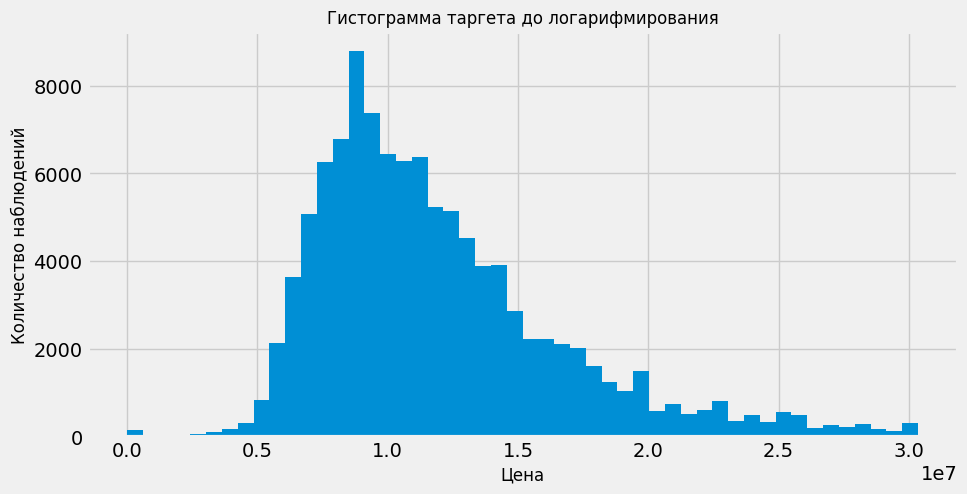

In [15]:
with mlflow.start_run(run_name='target_histplot_before', experiment_id=experiment_id) as run:
    plt.figure(figsize=(10, 5))
    plt.hist(data['price'], bins=50)
    plt.xlabel('Цена')
    plt.ylabel('Количество наблюдений')
    plt.title('Гистограмма таргета до логарифмирования')
    image_path = os.path.join(ARTIFACT_DIR, f"target_histplot_before.png")
    plt.savefig(image_path)
    mlflow.log_artifact(image_path)


In [16]:
# Хорошо подойдет разбиение на train/test с кросс-валидацией

# Прежде чем применять логарифмирование, проверяем, что все значения целевой переменной положительные,
#  так как логарифм от нуля или отрицательного числа не определен

# Почему я применяю логарифмирование таргета:

# 1. Сильный разброс значений таргета: значения таргета варьируются в широком диапазоне, логарифмирование помогает уменьшить этот разброс
# 2. Смещение распределения: логарифмирование может сделать распределение более симметричным


data['price'] = np.log1p(data['price'])


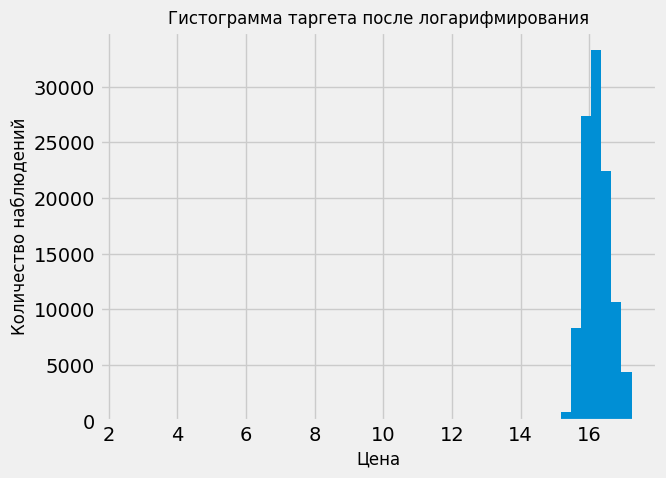

In [17]:
with mlflow.start_run(run_name='target_histplot_after', experiment_id=experiment_id) as run:
    plt.hist(data['price'], bins=50)
    plt.xlabel('Цена')
    plt.ylabel('Количество наблюдений')
    plt.title('Гистограмма таргета после логарифмирования')
    image_path = os.path.join(ARTIFACT_DIR, f"target_histplot_after.png")
    plt.savefig(image_path)
    mlflow.log_artifact(image_path)



In [18]:
Q1 = data['price'].quantile(0.25)
Q3 = data['price'].quantile(0.75)
IQR = Q3 - Q1

lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Использовали 1.5 межквартильных размаха для удаления выбросов
data = data[(data['price'] >= lower_bound) & (data['price'] <= upper_bound)]

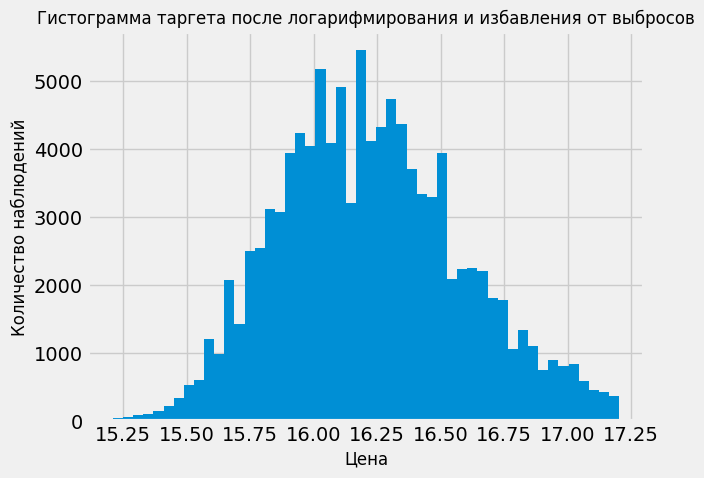

In [19]:

with mlflow.start_run(run_name='target_histplot_after_and_tail', experiment_id=experiment_id) as run:
    plt.hist(data['price'], bins=50)
    plt.xlabel('Цена')
    plt.ylabel('Количество наблюдений')
    plt.title('Гистограмма таргета после логарифмирования и избавления от выбросов')
    image_path = os.path.join(ARTIFACT_DIR, f"target_histplot_after_and_tail.png")
    plt.savefig(image_path)
    mlflow.log_artifact(image_path)

In [20]:
# Разбиваем на выборки, учитывая перемешивание данных для сохранения распределения таргета

train, test = train_test_split(data, shuffle=True, test_size=0.3, random_state=42)

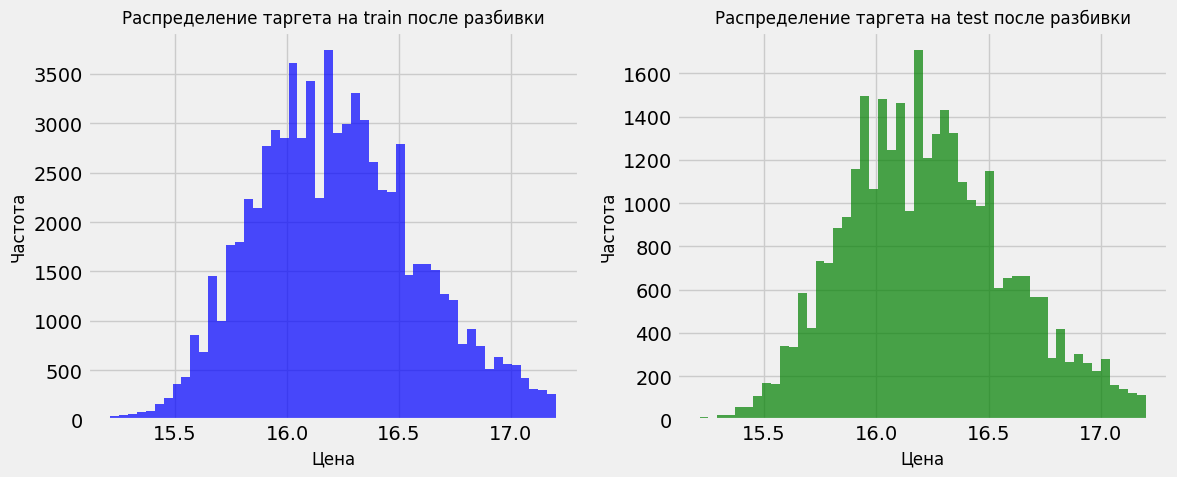

In [21]:
# Сравним распределение таргета на train и test
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 5))

axes[0].hist(train['price'], bins=50, color='blue', alpha=0.7)
axes[0].set_title('Распределение таргета на train после разбивки', fontsize=12)
axes[0].set_xlabel('Цена', fontsize=12)
axes[0].set_ylabel('Частота', fontsize=12)

# Гистограмма для test['price']
axes[1].hist(test['price'], bins=50, color='green', alpha=0.7)
axes[1].set_title('Распределение таргета на test после разбивки')
axes[1].set_xlabel('Цена')
axes[1].set_ylabel('Частота')

# Устанавливаем более удобное расположение между подграфиками
plt.tight_layout()


with mlflow.start_run(run_name='target_compare_test_and_train', experiment_id=experiment_id) as run:
    image_path = os.path.join(ARTIFACT_DIR, f"target_compare_test_and_train.png")
    plt.savefig(image_path)
    mlflow.log_artifact(image_path)



Проверим, что 2 эмпирических распрделения на train и test принадлежат одному распределению с помощью теста Колмогорова-Смирнова.

В контексте использования критерия Колмогорова-Смирнова для сравнения двух распределений, основная статистическая гипотеза обычно формулируется следующим образом:

- Нулевая гипотеза (H0): Распределения двух выборок идентичны, то есть обе выборки взяты из одного и того же распределения.

- Альтернативная гипотеза (H1): Распределения двух выборок различны, то есть они не идентичны.

Таким образом, при использовании критерия Колмогорова-Смирнова основная цель - проверить, можно ли отвергнуть нулевую гипотезу о том, что два распределения идентичны, на основе имеющихся данных. Если p-value меньше выбранного уровня значимости, мы можем отвергнуть нулевую гипотезу и сделать вывод о статистической разнице между распределениями.

In [22]:
statistic, p_value = ks_2samp(train['price'], test['price'])

alpha = 0.05  # Уровень значимости

if p_value > alpha:
    print("Распределения похожи (не отвергаем нулевую гипотезу)")
else:
    print("Распределения различаются (отвергаем нулевую гипотезу)")

print(f'p_value: {p_value:.2f}')

Распределения похожи (не отвергаем нулевую гипотезу)
p_value: 0.29


### Этап 2: Исследовательский Анализ Данных (EDA)



In [23]:
# Выше мы уже провели начальный выгрузку данных из БД и логарифмирование таргета и разделение на выборки
# EDA всегда проводится на train, изучим его подробнее

train

,building_type_int,latitude,longitude,ceiling_height,flats_count,floors_total,has_elevator,floor,kitchen_area,living_area,rooms,is_apartment,total_area,price,build_year
74582,4,55.688911,37.684544,2.699219,659,23,true,1,8.0,26.000000,1,false,37.000000,16.204273,1988
77336,1,55.733154,37.683975,2.699219,111,14,true,14,8.9,32.799999,2,false,53.700001,16.483433,1968
564,2,55.713730,37.479061,3.000000,159,15,true,13,13.0,36.000000,2,false,76.500000,17.062002,2006
51621,4,55.775288,37.642178,2.640625,190,12,true,12,8.0,30.000000,2,false,52.000000,16.951005,1981
36002,2,55.798882,37.389771,2.800781,240,24,true,9,8.0,19.000000,1,false,38.000000,16.147655,2012
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
55246,4,55.668560,37.761185,2.699219,196,17,true,4,13.3,44.799999,3,false,76.400002,16.759950,2001
77352,2,55.781590,37.830456,3.000000,98,7,true,7,11.0,31.000000,2,false,54.000000,16.118096,2006
104482,4,55.857822,37.569244,2.640625,354,9,true,2,6.0,27.000000,2,false,45.000000,15.710128,1971
865,4,55.795345,37.395561,2.640625,382,16,true,10,8.5,19.100000,1,false,38.299999,15.869634,1980


#### 2.1 Общий обзор датасета

In [24]:

train.info()

# Видим, что пропусков нет.
# 3 типа object, building_type_int оставим в этом типе, будем применять target_encoding

<class 'pandas.core.frame.DataFrame'>
Index: 74658 entries, 74582 to 15872
Data columns (total 15 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   building_type_int  74658 non-null  int8   
 1   latitude           74658 non-null  float64
 2   longitude          74658 non-null  float64
 3   ceiling_height     74658 non-null  float16
 4   flats_count        74658 non-null  int16  
 5   floors_total       74658 non-null  int8   
 6   has_elevator       74658 non-null  object 
 7   floor              74658 non-null  int8   
 8   kitchen_area       74658 non-null  float32
 9   living_area        74658 non-null  float32
 10  rooms              74658 non-null  int64  
 11  is_apartment       74658 non-null  object 
 12  total_area         74658 non-null  float32
 13  price              74658 non-null  float64
 14  build_year         74658 non-null  int16  
dtypes: float16(1), float32(3), float64(3), int16(2), int64(1), int8(3), obj

In [25]:
# Посмотрим распредления признаков

train.describe()


,building_type_int,latitude,longitude,ceiling_height,flats_count,floors_total,floor,kitchen_area,living_area,rooms,total_area,price,build_year
count,74658.000000,74658.000000,74658.000000,74658.000000,74658.000000,74658.00000,74658.000000,74658.000000,74658.000000,74658.000000,74658.000000,74658.000000,74658.000000
mean,3.509805,55.729425,37.597538,NaN,229.324600,13.13227,6.830909,8.166058,27.658010,1.951378,51.962021,16.223225,1984.587291
std,1.408259,0.106136,0.155428,0.000000,141.005087,5.17753,4.619795,3.027355,14.602069,0.821013,16.503761,0.360173,19.551357
min,0.000000,55.418503,37.150566,2.400391,1.000000,1.00000,1.000000,0.000000,0.000000,1.000000,14.140000,15.209277,1905.000000
25%,2.000000,55.647629,37.492329,2.640625,112.000000,9.00000,3.000000,6.000000,19.000000,1.000000,38.500000,15.955577,1969.000000
50%,4.000000,55.717884,37.588295,2.640625,198.000000,12.00000,6.000000,8.500000,28.485000,2.000000,49.000000,16.199676,1980.000000
75%,4.000000,55.815311,37.719639,2.730469,313.000000,17.00000,10.000000,10.000000,36.099998,3.000000,61.000000,16.454568,2003.000000
max,6.000000,56.011032,37.946411,3.070312,680.000000,30.00000,21.000000,17.139999,78.300003,5.000000,126.900002,17.202609,2023.000000




Видим высокий разброс в фиче flats_count, далее подробнее изучим ее распределение.

В среднем, высота потолка около 2.7м

Больше всего 2 комнатных квартир

Средняя площадь квартиры 52м2

Средний возраст дома 39 лет

Средняя цена 16.227826 (логарифмированное) -> около 11 миллионов


Таким образом, общая картина по квартирам такая: чаще всего продают 2 комантные квартиры площадью 52м2,
 с возрастом дома 39 лет за 11 миллионов в среднем

In [26]:
result = 16.227826
x = np.exp(result) - 1
print(x)

11159770.055869777


In [27]:
train.shape

(74658, 15)

In [28]:
# проверим, что в данных нет абсолютных дубликатов

train.drop_duplicates().shape


(74581, 15)

In [29]:

train = train.drop_duplicates()

#### 2.2  Анализ признаков для модели


 Phi_K является обобщением коэффициента корреляции Пирсона и предназначен для более точного измерения ассоциаций в данных,
 где традиционные методы могут быть неэффективны.

Когда использовать Phi_K (φk)

1. **Смешанные типы данных:** Когда у вас есть как числовые, так и категориальные признаки, и вы хотите понять их взаимосвязь.
2. **Нелинейные зависимости:** Phi_K может обнаруживать нелинейные зависимости, которые могут быть упущены традиционными методами корреляции.
3. **Большое количество уникальных значений:** Если у вас есть категориальные признаки с большим количеством уникальных значений, стандартные методы, такие как коэффициент Cramer’s V, могут быть неэффективны.
4. **Неравномерное распределение:** Phi_K хорошо справляется с неравномерно распределенными данными, где частотные методы могут давать искаженные результаты.

interval columns not set, guessing: ['building_type_int', 'ceiling_height', 'flats_count', 'floors_total', 'floor', 'kitchen_area', 'living_area', 'rooms', 'total_area', 'price', 'build_year']


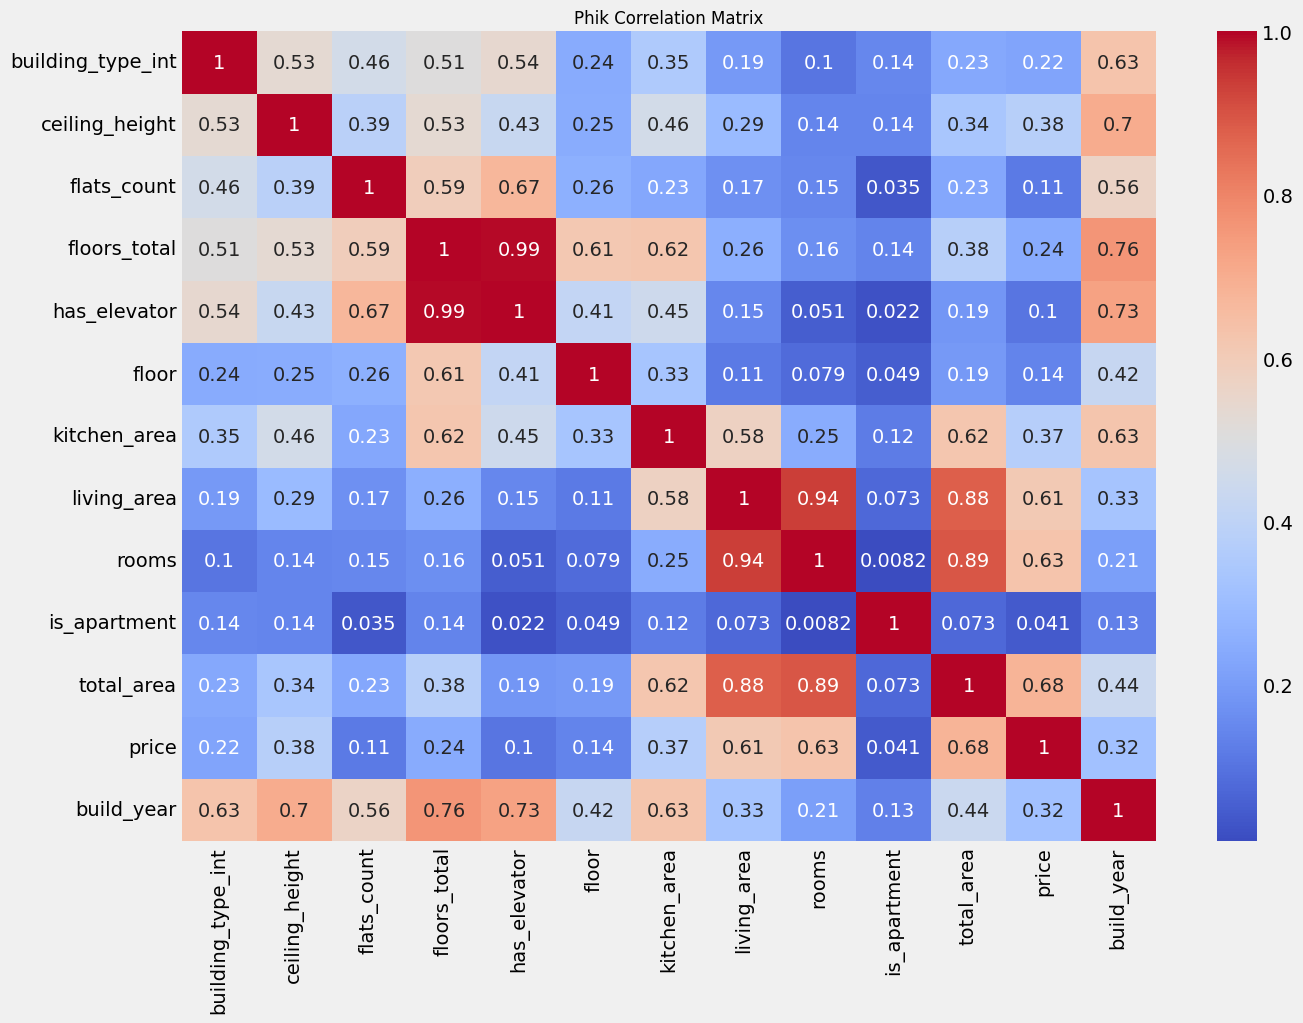

In [30]:
# проведем общий анализ фичей
# Построим корреляционную матрицу


# Вычислим матрицу корреляций phik
phik_matrix = train.drop(['latitude', 'longitude'], axis=1).phik_matrix()


with mlflow.start_run(run_name=RUN_NAME_EDA, experiment_id=experiment_id) as run:
    plt.figure(figsize=(14, 10))
    sns.heatmap(phik_matrix, annot=True, cmap='coolwarm')
    plt.title("Phik Correlation Matrix")
    image_path = os.path.join(ARTIFACT_DIR, f"phik_correlation_matrix.png")
    plt.savefig(image_path)
    mlflow.log_artifact(image_path)


Из интересного сразу видим прямую зависимость между тем, есть ли лифт и количеству этажей!))


также видим связь между возрастом дома, этажами и лифтом, предположу, что чем старше дом, тем меньше домов были с лифтами

In [31]:
# интересно посмотреть на связь между высотой потолка и возрастом дома

train['ceiling_height_bin'] = pd.qcut(train['ceiling_height'], q=3)

# Группировка и агрегация
grouped = train.groupby('ceiling_height_bin')['build_year'].agg(['mean', 'count']).reset_index()
grouped



# как видим, в новостройках высота потолков выше и равна 2.7м

,ceiling_height_bin,mean,count
0,"(2.399, 2.641]",1978.537713,45833
1,"(2.641, 2.699]",1992.605553,10085
2,"(2.699, 3.07]",1995.100252,18663


2024-06-05 16:12:38,859 INFO: Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2024-06-05 16:12:38,958 INFO: Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


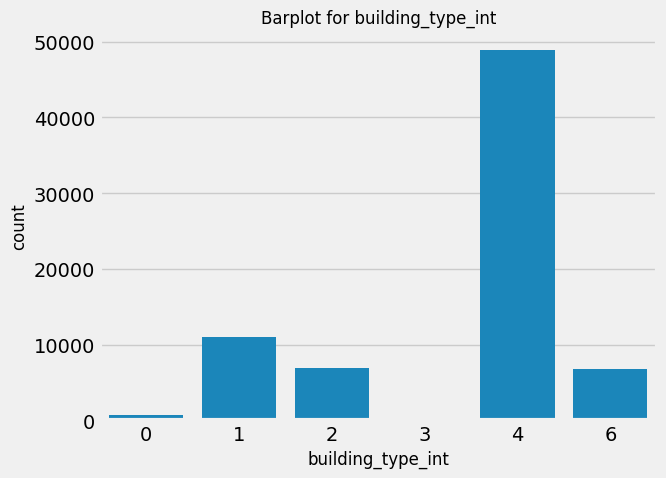

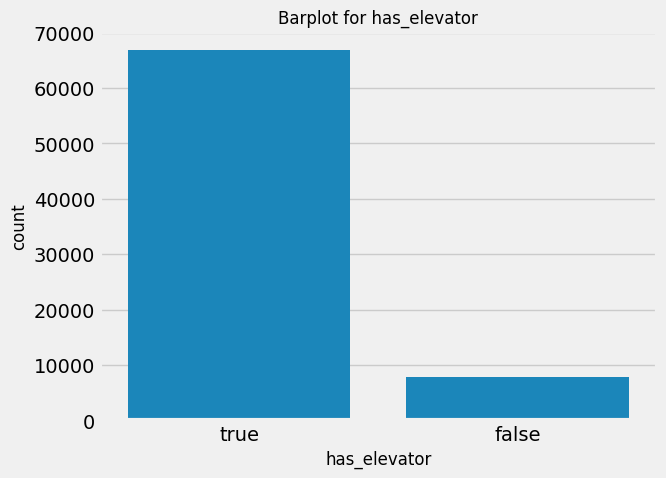

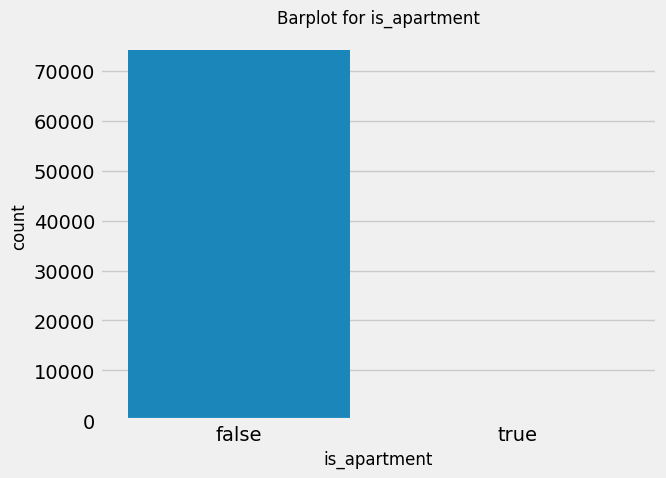

In [32]:
# рассмотрим категориальне фичи по отдельности

categorical_features = ['building_type_int', 'has_elevator', 'is_apartment']

# Построение barplot для категориальных фичей

with mlflow.start_run(run_name=RUN_NAME_EDA, experiment_id=experiment_id) as run:
    for feature in categorical_features:
        sns.countplot(data=train, x=feature)
        plt.title(f'Barplot for {feature}')
        image_path = os.path.join(ARTIFACT_DIR, f"{feature}_barplot.png")
        plt.savefig(image_path)
        mlflow.log_artifact(image_path)
        plt.show()
        # close закрывает работу с текущим изображением и освобождает память новому
        plt.close()



# Из столбчатых диаграм видно, что преобладает 4 тип строения (хотя нам это ни о чем не говорит, в описании нет данных, стоит запросить у аналитиков)
# В преобладающей части домой в данных присутствует лифт, в старых зданиях он есть не везде
# В данных практически нет апартаментов

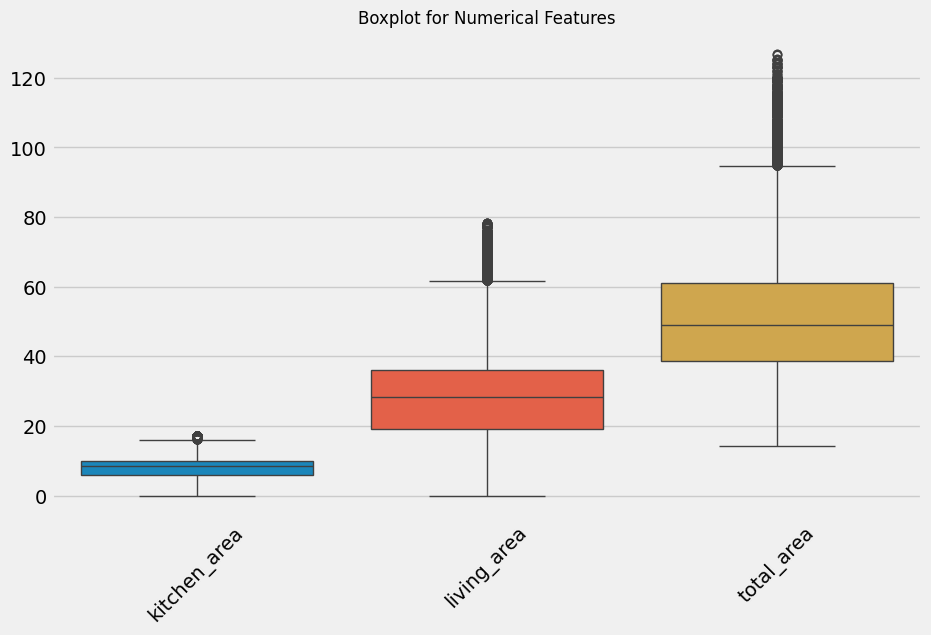

In [33]:
# Построение ящика с усами для числовых признаков. Видим хвосты 
numerical_features = ['kitchen_area', 'living_area', 'total_area']

# Построение boxplot для каждой фичи
plt.figure(figsize=(10, 6))
sns.boxplot(data=train[numerical_features])
plt.xticks(rotation=45)
plt.title('Boxplot for Numerical Features')
plt.show()

In [34]:
# Избавимся от хвостов с помощью IQR

numerical_features = ['kitchen_area', 'living_area', 'total_area']

def remove_outliers(df: pd.DataFrame, features: List[str]) -> pd.DataFrame:
    """
    Удаляет выбросы из DataFrame на основе метода межквартильного размаха (IQR).
    """
    for feature in features:
        Q1 = df[feature].quantile(0.25)
        Q3 = df[feature].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        df = df[(df[feature] >= lower_bound) & (df[feature] <= upper_bound)]
    return df

# Удаление выбросов
df_cleaned = remove_outliers(train, numerical_features)

print("DataFrame до удаления выбросов:")
print(train.shape)
print("\nDataFrame после удаления выбросов:")
print(df_cleaned.shape)

DataFrame до удаления выбросов:
(74581, 16)

DataFrame после удаления выбросов:
(72475, 16)


In [35]:
train = df_cleaned

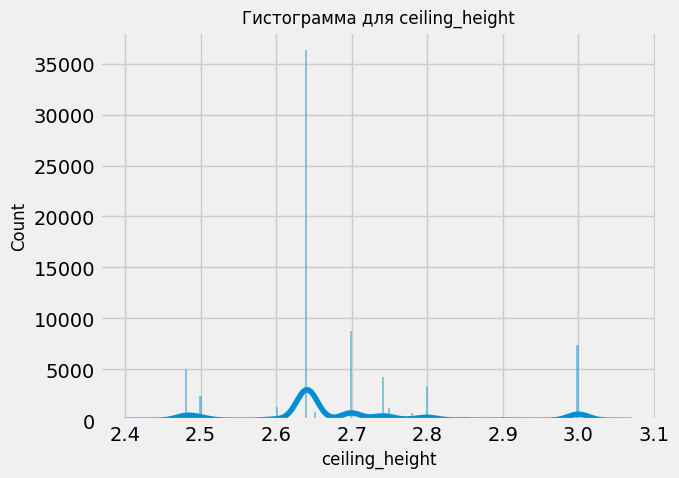

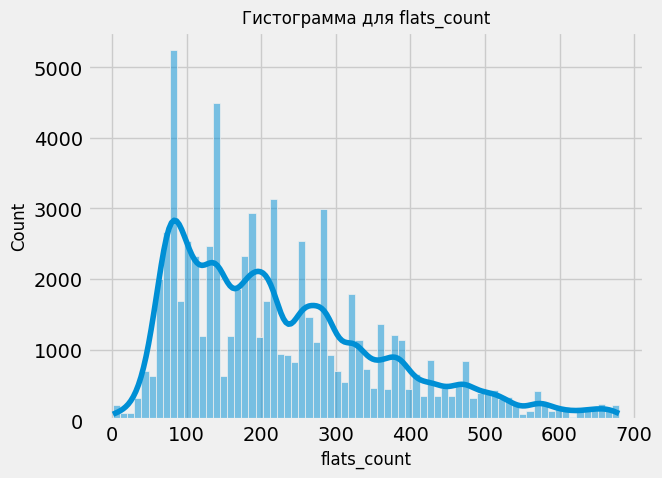

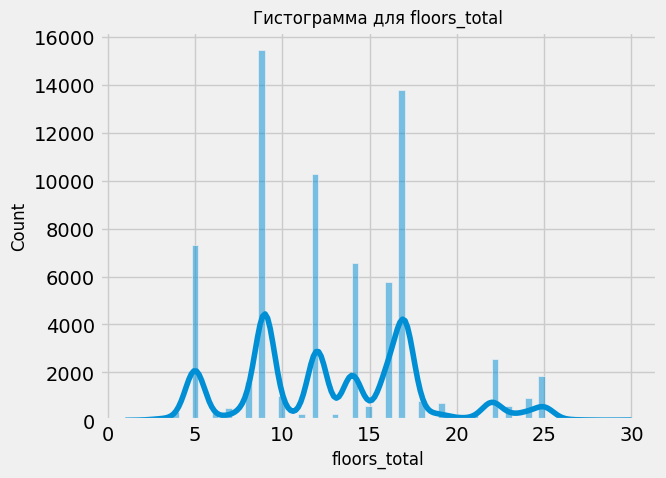

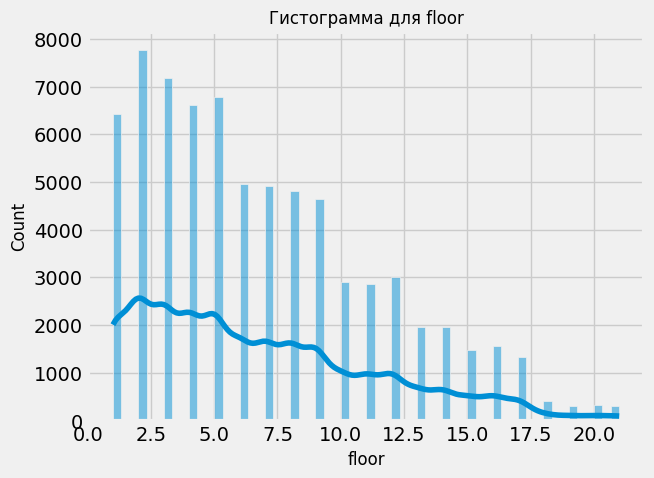

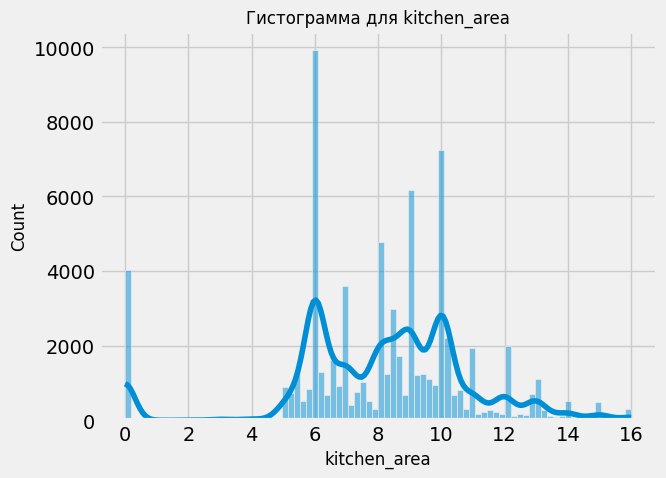

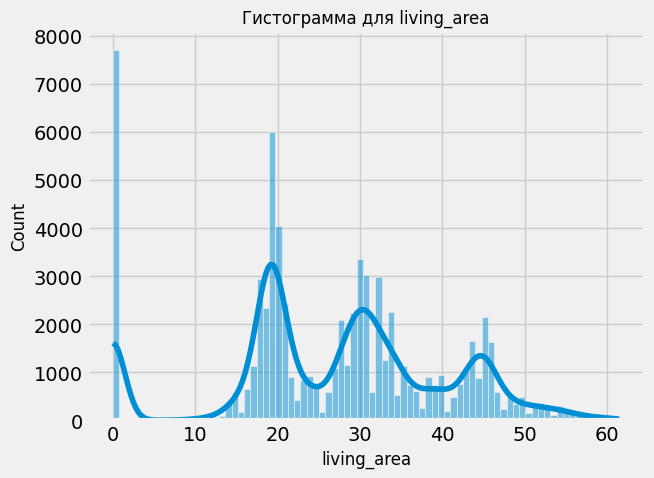

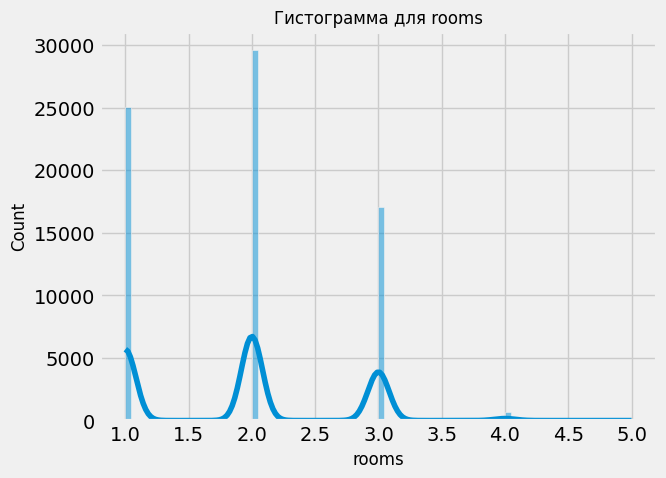

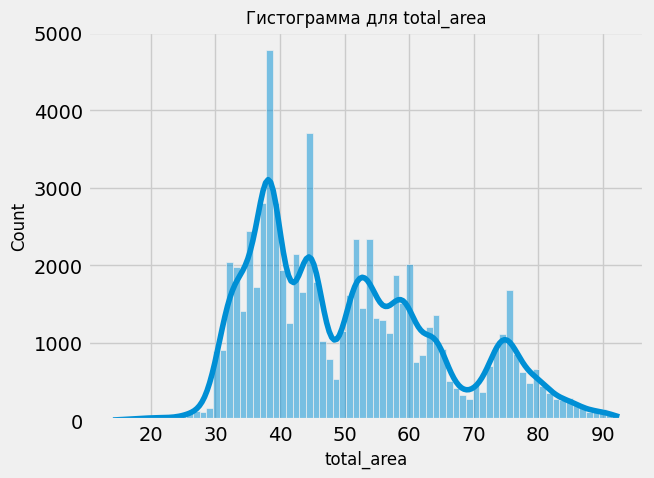

In [36]:
numerical_features = ['ceiling_height', 'flats_count', 'floors_total',
                      'floor', 'kitchen_area', 'living_area', 'rooms',
                      'total_area']
# Построение histplot для числовых значений
with mlflow.start_run(run_name=RUN_NAME_EDA, experiment_id=experiment_id) as run:
    for feature in numerical_features:
        sns.histplot(data=train, x=feature, kde=True)
        plt.title(f'Гистограмма для {feature}')
        image_path = os.path.join(ARTIFACT_DIR, f"{feature}_histplot.png")
        plt.savefig(image_path)
        mlflow.log_artifact(image_path)
        plt.show()
        # close закрывает работу с текущим изображением и освобождает память новому
        plt.close()


# из интересного - есть наблюдения, где очень маленькие жилая площадь и кухня, предположу, что это студии
# в них они не считаются в расчете.

# так же в высоте потолков видим пик около 2.65, стандартаная высота потолков в домах

# преобладают квартиры от 1 до 3 комнат, самые распространенные варианты

# также в основном дома продают не старше 70 лет, поскольку потом жилье считается аварийным

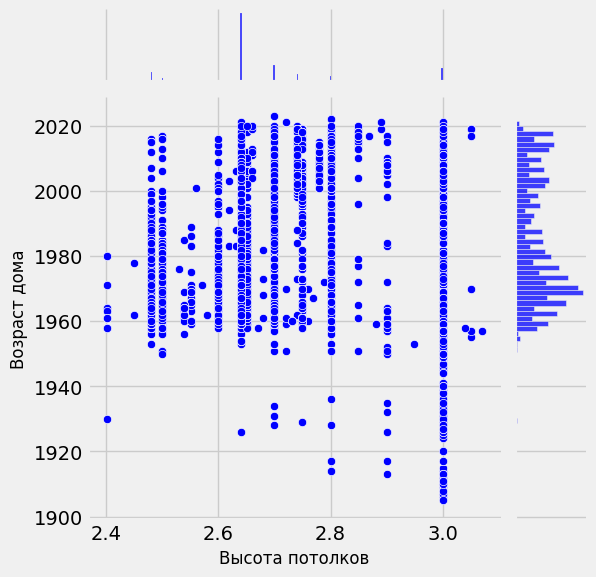

In [37]:
# Построение scatterplot для некоторых фичей
scatter_features = ['ceiling_height', 'build_year']  # замените на названия ваших фичей

x = train['ceiling_height']
y = train['build_year']

with mlflow.start_run(run_name=RUN_NAME_EDA, experiment_id=experiment_id) as run:
    sns.jointplot(x=x, y=y, kind='scatter', color='blue')
    plt.xlabel('Высота потолков')
    plt.ylabel('Возраст дома')
    image_path = os.path.join(ARTIFACT_DIR, f"ceiling_height_house_age_jointplot.png")
    plt.savefig(image_path)
    mlflow.log_artifact(image_path)
    plt.show()


# Можем заметить, что очень высокие потолки встречаются в старых домах

#### 2.3  Анализ целевой переменной

<Axes: ylabel='Frequency'>

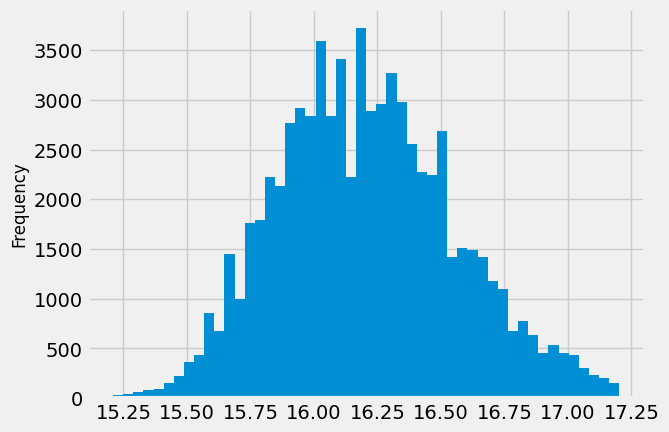

In [38]:
# После логарифмирования распредление целевой переменной выглядит так

train['price'].plot.hist(bins=50)

# Распределение имеет небольшой хвост слева. Благодаря лагорифмированию мы избавились от огромного диапазона значений

#### 2.4  Анализ целевой переменной в зависимости от различных признаков

In [39]:
# По анализу phik можем сказать, что особое влияние на цену квартиры оказывают:
# общая площадь квартиры
# количество комнат
# жилая площадь
# площадь кухни
# высота потолков

# 5 этих фичи показывают наибольшую зависимость с таргетом

In [40]:
# построим 5 сводных таблиц, чтобы оценить влияние этих признаков на цену
# но для начала эти числовые значения нужно разбить на интервалы



In [41]:
# сначала рассмотрим зависимость цены от общей площади, разобьем с помощью qcut

train['total_area_bin'] = pd.qcut(train['total_area'], q=4)

# Группировка и агрегация
grouped = train.groupby('total_area_bin')['price'].agg(['mean', 'count']).reset_index()
grouped

# как видим, чем больше общая площадь, тем больше цена, логично)


,total_area_bin,mean,count
0,"(14.139000000000001, 38.3]",15.941136,18293
1,"(38.3, 47.3]",16.071978,17952
2,"(47.3, 60.0]",16.303698,18673
3,"(60.0, 92.5]",16.522642,17557


In [42]:
# для комнат, площади кухни аналогично, а вот проверим высоту потолков

train['ceiling_height_bin'] = pd.qcut(train['ceiling_height'], q=3)

# Группировка и агрегация
grouped = train.groupby('ceiling_height_bin')['price'].agg(['mean', 'count']).reset_index()
grouped

# как видим, цена выше там, где больше высота потолков

,ceiling_height_bin,mean,count
0,"(2.399, 2.641]",16.145629,45200
1,"(2.641, 2.699]",16.242178,9835
2,"(2.699, 3.07]",16.349660,17440


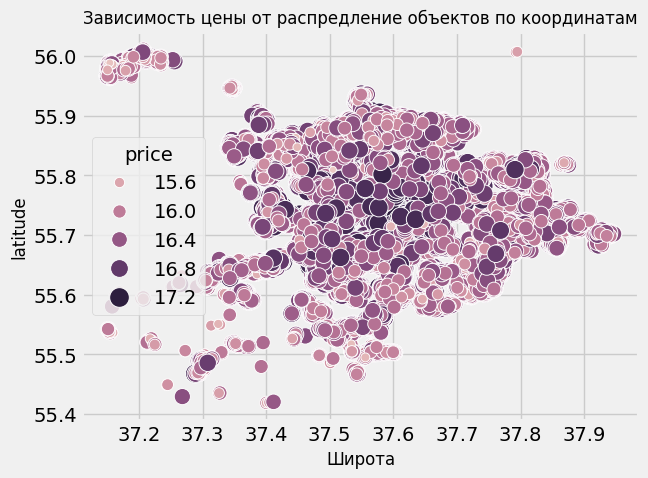

In [43]:
# Построим график зависимости координат от цены

plt.figsize=(12, 8)

sns.scatterplot(data=train, x='longitude', y='latitude', hue='price', size='price', sizes=(20, 200))
plt.xlabel('Долгота')
plt.xlabel('Широта')
plt.title('Зависимость цены от распредление объектов по координатам')


# Как видим, в центре Питера цены выше


with mlflow.start_run(run_name=RUN_NAME_EDA, experiment_id=experiment_id) as run:
    image_path = os.path.join(ARTIFACT_DIR, f"price_compare_longtitude_latitude.png")
    plt.savefig(image_path)
    mlflow.log_artifact(image_path)
    plt.show()


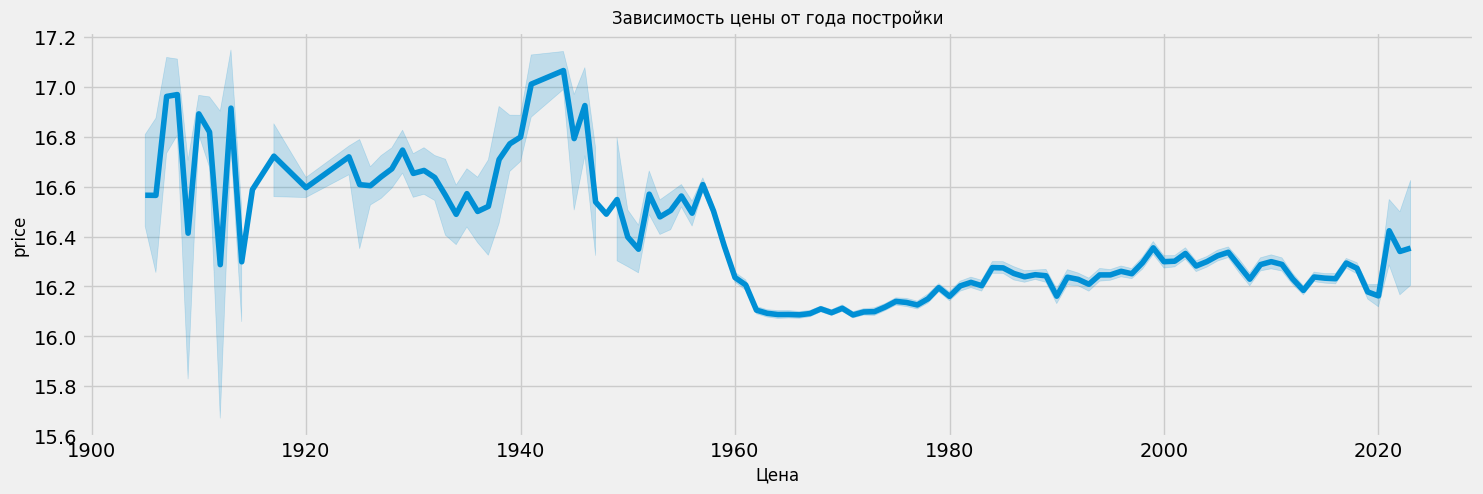

In [44]:
plt.figure(figsize=(16, 5))
sns.lineplot(train, x='build_year', y='price')
plt.xlabel('Год постройки')
plt.xlabel('Цена')
plt.title('Зависимость цены от года постройки')


# Как видим, есть старые дорогие дома, возможно какие-то раритетные) А ценообразование новых домов зависит от года постройки, видно
# Что чем новее дом (не из раритетных), тем его цена выше.


with mlflow.start_run(run_name=RUN_NAME_EDA, experiment_id=experiment_id) as run:
    image_path = os.path.join(ARTIFACT_DIR, f"year_price.png")
    plt.savefig(image_path)
    mlflow.log_artifact(image_path)
    plt.show()

#### 2.5 Выводы после EDA

Видим, что пропусков в данных нет, значит этап с Airflow отработал корректно. Удалил дубликаты из датасета, это улучшит обобщаю способность модели.



Имеем типа object: из которого признак building_type_int оставим в этом типе, к нему будем применять target_encoding. Что означает этот признак
с его значениями непонятно, стоит обратиться к аналитикам за объяснениями.



Проведя статистический анализ фичей приходим к таким выводам:
* видим высокий разброс в фиче flats_count.
* В среднем, высота потолка около 2.7м
* Больше всего 2 комнатных квартир
* Средняя площадь квартиры 52м2
* Средний возраст дома 39 лет
* Средняя цена 16.227826 (логарифмированное) -> около 11 миллионов



Таким образом, **общая картина по квартирам такая**: чаще всего продают 2 комантные квартиры площадью 52м2, с возрастом дома 39 лет за 11 миллионов в среднем.



Из столбчатых диаграм видно, что преобладает 4 тип строения (хотя нам это ни о чем не говорит, в описании нет данных, стоит запросить у аналитиков)
В преобладающей части домой в данных присутствует лифт, в старых зданиях он есть не везде
В данных практически нет апартаментов.



Из интересного в гистограммах - есть наблюдения, где очень маленькие жилая площадь и кухня, предположу, что это студии.
Так же в высоте потолков видим пик около 2.65, стандартаная высота потолков в домах.
Преобладают квартиры от 1 до 3 комнат, самые распространенные варианты
также в основном дома продают не старше 70 лет, поскольку потом жилье считается аварийным



По jointpltot Можем заметить, что очень высокие потолки встречаются в старых домах.


Проведя анализ с помощью phik можем сказать следующее:
Из интересного сразу видим прямую зависимость между тем, есть ли лифт и количеству этажей!))
также видим связь между возрастом дома, этажами и лифтом, предположу, что чем старше дом, тем меньше домов были с лифтами
как видим, в новостройках высота потолков выше и равна 2.7м

По анализу phik можем сказать, **что особое влияние на цену квартиры оказывают:**
* общая площадь квартиры
* количество комнат
* жилая площадь
* площадь кухни
* высота потолков

Как видим, есть старые дорогие дома, возможно какие-то раритетные) А ценообразование новых домов зависит от года постройки, видно что чем новее дом (не из раритетных), тем его цена выше.

Как видим, чем больше общая площадь, тем больше цена, логично) для комнат, площади кухни аналогично. Цена также выше там, где больше высота потолков. Возможно, элитное жилье. Также цена объектов в центре выше!

**Распределение целевой переменной имеет небольшой хвост слева. Благодаря логарифмированию мы избавились от огромного диапазона значений!**


#### 2.6  логирование артефактов в MLflow

In [45]:
# создание нового запуска для логирования файлов

with mlflow.start_run(experiment_id=experiment_id, run_name=RUN_NAME_EDA) as run:
    local_conclusion_path = os.path.join(ARTIFACT_DIR, "conclusion_EDA.md")
    os.system(f"cp {conclusion_path} {local_conclusion_path}")
    # Логирование файла conclusion_EDA.md
    mlflow.log_artifact(local_conclusion_path)

    # Копирование Jupyter Notebook в директорию артефактов
    local_notebook_path = os.path.join(ARTIFACT_DIR, "PROJECT.ipynb")
    os.system(f"cp {notebook_path} {local_notebook_path}")
    # Логирование Jupyter Notebook
    mlflow.log_artifact(local_notebook_path)
    print("Артефакты успешно зарегистрированы в mlflow и сохранены локально в папку ARTIFACT_EDA.")



Артефакты успешно зарегистрированы в mlflow и сохранены локально в папку ARTIFACT_EDA.


### Этап 3: Генерация Признаков и Обучение Новой Версии Модели



In [46]:
# признаки, которые я разбивал по квантилям в датасете имеют тип category, учту это, чтобы в select_dtypes они не попали
train.dtypes

building_type_int         int8
latitude               float64
longitude              float64
ceiling_height         float16
flats_count              int16
floors_total              int8
has_elevator            object
floor                     int8
kitchen_area           float32
living_area            float32
rooms                    int64
is_apartment            object
total_area             float32
price                  float64
build_year               int16
ceiling_height_bin    category
total_area_bin        category
dtype: object

**Масштабирование и другие преобразования не стоит делать до создания новых фичей, поскольку так мы можем получить новый объекты, которые будет сложнее интерпретировать или которые станут менее значимыми, поскольку преобразование масштабирования/... может изменить отношения между переменными.**

Для sklearn Feature Engineering буду использовать фичи:
* kitchen_area
* living_area
* total_area
* house_age
* ceiling_height

Для них использую PolynomialFeatures, KBinsDiscretizer и SplineTransformer


Если у нас есть 5 исходных признаков: kitchen_area, living_area, total_area, и house_age, ceiling_height то полиномиальные признаки второй степени будут включать:
- Все исходные признаки (1 степень): kitchen_area, living_area, total_area, house_age, ceiling_height
- Квадраты каждого признака (2 степень): kitchen_area^2, living_area^2, total_area^2, house_age^2, ceiling_height^2
- Все возможные пары взаимодействий (произведения признаков): kitchen_area \* living_area, kitchen_area \* total_area, и т.д.


KBinsDiscretizer делит каждый числовой признак на несколько интервалов (бинов). В вашем случае используется параметр n_bins=5, что означает деление каждого признака на 5 бинов. То есть, число фичей будет 5
Таким образом, будет создано 4 новых признака:
- kbins_kitchen_area
- kbins_living_area
- kbins_total_area
- kbins_house_age
- kbins_ceiling_height


SplineTransformer создает сплайн-признаки для каждого числового признака. В вашем случае используется параметр n_knots=3, что означает создание 3 узлов (knots). По умолчанию, это приводит к созданию ( n_knots + degree - 1) новых признаков для каждого исходного признака (где degree по умолчанию равен 3). Значит у нас создастся 6 новых фичей для каждого признака)



In [47]:
# Выделение признаков для предобработки, которые учитываться не будут
train = train.drop(['ceiling_height_bin', 'total_area_bin'], axis=1)


#### 3.1 Ручная генерация признаков

In [48]:
# cгенерирую признак возраста дома. Сразу его сделаю и для test
train['house_age'] = 2024 - train['build_year']
test['house_age'] = 2024 - test['build_year']

train = train.drop(['build_year'], axis=1)
test = test.drop(['build_year'], axis=1)

In [49]:
# У нас есть координаты объектов, на основании этого можно создать признак расстояня до цента Питера
# Используем geopy
# За координаты центра возьмем Центр Невского проспекта

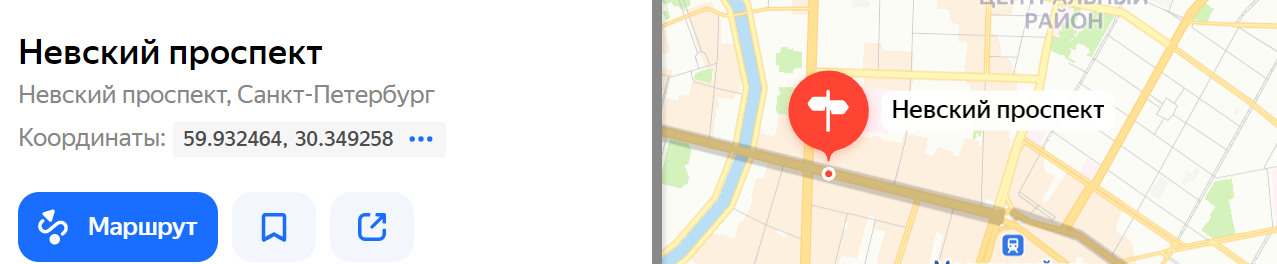

In [50]:
center_coords = (59.932464, 30.349258)

def calculate_distance(row: pd.Series) -> float:
    """Расчет километража от объекта до центра Питера"""
    point_coords = (row['latitude'], row['longitude'])
    return geodesic(point_coords, center_coords).kilometers


In [51]:
# Создаем признак километража до центра

train['distance_to_center'] = train.apply(calculate_distance, axis=1)

In [52]:
test['distance_to_center'] = test.apply(calculate_distance, axis=1)

In [53]:
# Удалим широту и долготу из датафреймов

train = train.drop(['latitude', 'longitude'], axis=1)
test = test.drop(['latitude', 'longitude'], axis=1)

#### 3.2 Feature Engineering c sklearn

In [54]:
# Используем FE для создания новых признаков
# Для них использую PolynomialFeatures, KBinsDiscretizer и SplineTransformer


poly_transformer = PolynomialFeatures(degree=POLY_DEGREE, include_bias=False)
kbins_transformer = KBinsDiscretizer(n_bins=KBINS_N_BINS, encode='ordinal', strategy='uniform')
spline_transformer = SplineTransformer(n_knots=SPLINE_K_NOTS, degree=SPLINE_DEGREE)


catboost_category_encoder = CatBoostEncoder(return_df=False)
ohe_encoder = OneHotEncoder(drop='if_binary')



#### 3.3 Автоматическая генерация признаков (AutoFeat)

**При feateng_steps=1 новые фичи для столбцов не генерировались, решение оказалось повышение числа итераций алгоритма. Более высокий параметр feateng_steps позволяет алгоритму выполнять более глубокий анализ и создавать более сложные признаки.**

In [55]:

feature_for_autofeat = ['kitchen_area',
                        'living_area',
                        'total_area',
                        'house_age',
                        'ceiling_height']

feature_for_kbins_transformer = ['house_age', 'ceiling_height']
feature_for_poly_spline_transformer = ['kitchen_area', 'living_area', 'total_area', 'ceiling_height']

feature_for_OHE = ['is_apartment', 'has_elevator']
feature_for_target_encoding = ['building_type_int', 'rooms']

feature_tail_scaler = ['flats_count', 'floors_total', 'floor', 'distance_to_center']

poly_transformer = PolynomialFeatures(degree=POLY_DEGREE, include_bias=False)
kbins_transformer = KBinsDiscretizer(n_bins=KBINS_N_BINS, encode='ordinal', strategy='uniform')
spline_transformer = SplineTransformer(n_knots=SPLINE_K_NOTS, degree=SPLINE_DEGREE)


catboost_category_encoder = CatBoostEncoder(return_df=False)
ohe_encoder = OneHotEncoder(drop='if_binary')


afc = AutoFeatRegressor(feateng_cols=feature_for_autofeat,
                        feateng_steps=AFC_FEATENG_STEPS,
                        max_gb=AFC_MAX_GB,
                        transformations=AFC_TRANSFORMATION,
                        n_jobs=AFC_N_JOBS)



poly_scaler_pipeline = Pipeline(steps=[
    ('poly_spline_auto', poly_transformer),
    ('scaler', StandardScaler())
])


spline_scaler_pipeline = Pipeline(steps=[
    ('spline_spline_auto', spline_transformer),
    ('scaler', StandardScaler())
])

# переопределили класс transformer
class AutoFeatWrapper(BaseEstimator, TransformerMixin):
    def __init__(self, feateng_cols, feateng_steps=AFC_FEATENG_STEPS, max_gb=AFC_MAX_GB, transformations=AFC_TRANSFORMATION, n_jobs=AFC_N_JOBS):
        self.feateng_cols = feateng_cols
        self.feateng_steps = feateng_steps
        self.max_gb = max_gb
        self.transformations = transformations
        self.n_jobs = n_jobs
        self.afc = AutoFeatRegressor(feateng_cols=self.feateng_cols,
                                     feateng_steps=self.feateng_steps,
                                     max_gb=self.max_gb,
                                     transformations=self.transformations,
                                     n_jobs=self.n_jobs)
        
    def fit(self, X, y=None):
        self.afc.fit(X, y)
        return self
    
    def transform(self, X):
        return self.afc.transform(X)
    
    def get_feature_names_out(self, input_features=None):
        # Преобразуем данные и возвращаем имена фичей из DataFrame
        transformed_X = self.afc.transform(pd.DataFrame(np.zeros((1, len(self.feateng_cols))), columns=self.feateng_cols))
        return transformed_X.columns.tolist()

# Используем новый обертчик в вашем пайплайне

autofeat_scaler_pipeline = Pipeline(steps=[
    ('autofeat_spline_auto', AutoFeatWrapper(feateng_cols=feature_for_autofeat)),
    ('scaler', StandardScaler())
])


tail_scaler_pipeline = Pipeline(steps=[
    ('tail_feature_scaler', StandardScaler())
])

preprocessor = ColumnTransformer(transformers=[
    ('poly', poly_scaler_pipeline, feature_for_poly_spline_transformer),
    ('spline', spline_scaler_pipeline, feature_for_poly_spline_transformer),
    ('afc', autofeat_scaler_pipeline, feature_for_autofeat),
    ('tail_scaler', tail_scaler_pipeline, feature_tail_scaler),
    ('category_encoder', catboost_category_encoder, feature_for_target_encoding),
    ('ohe', ohe_encoder, feature_for_OHE),
    ('kbins', kbins_transformer, feature_for_kbins_transformer)
],  remainder='passthrough',
    verbose_feature_names_out=True )


preprocessor

ColumnTransformer(remainder='passthrough',
                  transformers=[('poly',
                                 Pipeline(steps=[('poly_spline_auto',
                                                  PolynomialFeatures(include_bias=False)),
                                                 ('scaler', StandardScaler())]),
                                 ['kitchen_area', 'living_area', 'total_area',
                                  'ceiling_height']),
                                ('spline',
                                 Pipeline(steps=[('spline_spline_auto',
                                                  SplineTransformer(n_knots=3)),
                                                 ('scaler', StandardScaler())]),
                                 ['kitchen_...
                                 Pipeline(steps=[('tail_feature_scaler',
                                                  StandardScaler())]),
                                 ['flats_count', 'floors_total', 'floor',
                                  'distance_to_center']),
                                ('category_encoder',
                                 CatBoostEncoder(return_df=False),
                                 ['building_type_int', 'rooms']),
                                ('ohe', OneHotEncoder(drop='if_binary'),
                                 ['is_apartment', 'has_elevator']),
                                ('kbins',
                                 KBinsDiscretizer(encode='ordinal',
                                                  strategy='uniform'),
                                 ['house_age', 'ceiling_height'])])

In [56]:
preprocessor.fit(train, train['price'])


ColumnTransformer(remainder='passthrough',
                  transformers=[('poly',
                                 Pipeline(steps=[('poly_spline_auto',
                                                  PolynomialFeatures(include_bias=False)),
                                                 ('scaler', StandardScaler())]),
                                 ['kitchen_area', 'living_area', 'total_area',
                                  'ceiling_height']),
                                ('spline',
                                 Pipeline(steps=[('spline_spline_auto',
                                                  SplineTransformer(n_knots=3)),
                                                 ('scaler', StandardScaler())]),
                                 ['kitchen_...
                                 Pipeline(steps=[('tail_feature_scaler',
                                                  StandardScaler())]),
                                 ['flats_count', 'floors_total', 'floor',
                                  'distance_to_center']),
                                ('category_encoder',
                                 CatBoostEncoder(return_df=False),
                                 ['building_type_int', 'rooms']),
                                ('ohe', OneHotEncoder(drop='if_binary'),
                                 ['is_apartment', 'has_elevator']),
                                ('kbins',
                                 KBinsDiscretizer(encode='ordinal',
                                                  strategy='uniform'),
                                 ['house_age', 'ceiling_height'])])

In [57]:
train_after_fe = pd.DataFrame(preprocessor.transform(train), columns=preprocessor.get_feature_names_out())

In [58]:
train_after_fe

,poly__kitchen_area,poly__living_area,poly__total_area,poly__ceiling_height,poly__kitchen_area^2,poly__kitchen_area living_area,poly__kitchen_area total_area,poly__kitchen_area ceiling_height,poly__living_area^2,poly__living_area total_area,poly__living_area ceiling_height,poly__total_area^2,poly__total_area ceiling_height,poly__ceiling_height^2,spline__kitchen_area_sp_0,spline__kitchen_area_sp_1,spline__kitchen_area_sp_2,spline__kitchen_area_sp_3,spline__kitchen_area_sp_4,spline__living_area_sp_0,spline__living_area_sp_1,spline__living_area_sp_2,spline__living_area_sp_3,spline__living_area_sp_4,spline__total_area_sp_0,spline__total_area_sp_1,spline__total_area_sp_2,spline__total_area_sp_3,spline__total_area_sp_4,spline__ceiling_height_sp_0,spline__ceiling_height_sp_1,spline__ceiling_height_sp_2,spline__ceiling_height_sp_3,spline__ceiling_height_sp_4,afc__kitchen_area,afc__living_area,afc__total_area,afc__house_age,afc__ceiling_height,afc__1/house_age,afc__house_age/total_area,afc__house_age*living_area,afc__house_age*kitchen_area,afc__living_area/total_area,afc__kitchen_area/total_area,afc__kitchen_area*total_area,afc__kitchen_area*living_area,afc__total_area*log(house_age),afc__sqrt(kitchen_area)/house_age,afc__sqrt(living_area)/total_area,afc__ceiling_height*log(total_area),afc__log(total_area)/ceiling_height,afc__log(ceiling_height)/ceiling_height,tail_scaler__flats_count,tail_scaler__floors_total,tail_scaler__floor,tail_scaler__distance_to_center,category_encoder__building_type_int,category_encoder__rooms,ohe__is_apartment_true,ohe__has_elevator_true,kbins__house_age,kbins__ceiling_height,remainder__price
0,-0.028034,-0.068882,-0.930621,0.101758,-0.223681,-0.145496,-0.543178,-0.022043,-0.320610,-0.474303,-0.061195,-0.863993,-0.874656,0.075891,-0.268016,-0.164538,0.684643,-0.299743,-0.304645,-0.402315,-0.062533,0.740643,-0.429341,-0.340570,0.560333,1.052722,-0.307854,-0.828483,-0.352981,-0.442524,-0.398238,0.820733,-0.139868,-0.343615,-0.028034,-0.068882,-0.930621,-0.193553,0.101758,-0.316083,0.183410,-0.185364,-0.071837,0.892331,0.753147,-0.543178,-0.145496,-0.759379,-0.275647,1.050528,-0.685807,-0.989699,0.700187,3.050830,1.941908,-1.264861,0.607362,4.0,1.0,0.0,1.0,1.0,2.0,16.204273
1,0.278242,0.429745,0.204595,0.101758,0.117911,0.417608,0.233505,0.271998,0.223248,0.241486,0.429427,0.059624,0.198376,0.075891,-0.268016,-0.479638,0.591435,0.105328,-0.291641,-0.414458,-0.656127,0.858584,0.165143,-0.337384,-0.569639,-0.511290,1.093492,-0.046105,-0.352973,-0.442524,-0.398238,0.820733,-0.139868,-0.343615,0.278242,0.429745,0.204595,0.837399,0.101758,-0.568236,0.314745,0.936407,1.258137,0.427012,-0.026453,0.233504,0.417608,0.720428,-0.475034,0.210557,0.303504,0.245640,0.700187,-0.836794,0.184852,1.565224,0.270968,1.0,2.0,0.0,1.0,2.0,2.0,16.483433
2,1.673499,0.664393,1.754471,2.433021,2.134454,1.599106,2.438808,2.084800,0.522708,1.130348,0.949744,1.869771,2.211088,2.482520,-0.268016,-1.156326,-1.411024,2.225920,1.925100,-0.414458,-0.858829,0.709747,0.529159,-0.287050,-0.569639,-1.404029,-1.421710,2.001618,1.469586,-0.452735,-1.815840,-2.033613,2.732966,2.948554,1.673499,0.664393,1.754471,-1.121410,2.433021,0.389947,-1.203464,-0.544012,-0.413181,-0.282915,0.038396,2.438808,1.599106,0.808115,0.683990,-0.550113,2.527008,-0.022924,-2.038609,-0.496272,0.380081,1.347525,-0.304829,2.0,2.0,0.0,1.0,0.0,4.0,17.062002
3,-0.028034,0.224428,0.089034,-0.352385,-0.223681,0.069224,-0.030883,-0.078780,-0.015927,0.061178,0.180419,-0.049946,0.016616,-0.363370,-0.268016,-0.164538,0.684643,-0.299743,-0.304645,-0.414410,-0.437466,0.883265,-0.112410,-0.340570,-0.569041,-0.379638,1.083056,-0.165787,-0.352981,-0.268747,0.303144,0.371842,-0.460830,-0.343615,-0.028034,0.224428,0.089034,0.167280,-0.352385,-0.431018,-0.091172,0.255474,0.282148,0.255482,-0.210067,-0.030883,0.069224,0.356033,-0.376466,0.174998,-0.009738,0.429721,0.456268,-0.276352,-0.205605,1.129826,-0.195439,4.0,2.0,0.0,1.0,1.0,1.0,16.951005
4,-0.028034,-0.582174,-0.862644,0.888937,-0.223681,

#### 3.4 Обучение новой версии модели

In [59]:
# Тут предлагаю получить сами датасеты после FE и работать дальше с ними. Потому что ВМ очень часто умирает он нагрузки....

train_after_fe = pd.concat(
    [pd.DataFrame(preprocessor.transform(train), columns=preprocessor.get_feature_names_out()), 
     train[['price']].reset_index(drop=True)], 
    axis=1
)

test_after_fe = pd.concat(
    [pd.DataFrame(preprocessor.transform(test), columns=preprocessor.get_feature_names_out()), 
     test[['price']].reset_index(drop=True)], 
    axis=1
)

In [60]:
# Залогируем:
# новый датасет после feature engineering


with mlflow.start_run(run_name='RUN_ARTIFACT_FE_dataset', experiment_id=experiment_id) as run:
    csv_path = os.path.join(DATA_DIR_PATH, 'datasets_with_FE.csv')
    train_after_fe.to_csv(csv_path, index=False)

    mlflow.log_artifact(csv_path)

    mlflow.sklearn.log_model(preprocessor, 'preprocessor_FE')
    mlflow.log_params(preprocessor.get_params())

2024/06/05 16:14:58 WARNING mlflow.sklearn: Model was missing function: predict. Not logging python_function flavor!


In [61]:
model = DecisionTreeRegressor(max_depth=MODEL_MAX_DEPTH, random_state=RANDOM_STATE)
model.fit(train_after_fe.drop(['price', 'remainder__price'], axis=1), train_after_fe['price'])

DecisionTreeRegressor(max_depth=10, random_state=42)

In [62]:
result_fe = evaluate_model(model, train_after_fe.drop(['price', 'remainder__price'], axis=1), train_after_fe['price'],
                           test_after_fe.drop(['price', 'remainder__price'], axis=1), test_after_fe['price'],
                           cv_strategy=KFold(n_splits=N_SPLITS))


In [63]:
result_df = append_result_to_df(result_fe, "FE_model", result_df)

Сравнительная таблица после добавления модели FE_model


,cv_neg_root_mean_squared_error,cv_r2,cv_neg_mean_absolute_error,fit_time,score_time,test_rmse,test_r2,test_mae,model
0,-0.257,0.508,-0.199,0.779,0.022,0.252,0.335,0.194,baseline_model
1,-0.229,0.57,-0.182,3.9,0.018,0.226,0.605,0.181,FE_model


In [64]:
result_df

,cv_neg_root_mean_squared_error,cv_r2,cv_neg_mean_absolute_error,fit_time,score_time,test_rmse,test_r2,test_mae,model
0,-0.257,0.508,-0.199,0.779,0.022,0.252,0.335,0.194,baseline_model
1,-0.229,0.57,-0.182,3.9,0.018,0.226,0.605,0.181,FE_model


In [65]:
# Сохраним результаты cv и залогируем модель, ее параметры

os.makedirs('cv_results', exist_ok=True)

# сохраняем локально словарь с метриками
path_result_cv = os.path.join(CV_RESULTS_PATH, "cv_res_FE.json")
with open(path_result_cv, 'w') as json_file:
    json.dump(result_fe, json_file)



#### 3.5 Логирование артефактов в MLflow

In [66]:

# Залогируем модель в mlflow
pip_requirements = "../requirements.txt"
signature = mlflow.models.infer_signature(train_after_fe.drop(['price'], axis=1), train_after_fe['price'])
input_example = train_after_fe.drop(['price'], axis=1)[:10]
metadata = {"target_name": "price"}


with mlflow.start_run(run_name='model_with_FE_pipeline', experiment_id=experiment_id) as run:
    # сохранение модели
    model_info = mlflow.sklearn.log_model(
        sk_model=model,
        artifact_path="models",
        registered_model_name="model_with_feature_engineering",
        signature=signature,
        pip_requirements=pip_requirements,
        input_example=input_example,
        metadata=metadata
)   
    # сохранение параметров
    mlflow.log_params(model.get_params())

    # сохранение метрик на cv + test
    mlflow.log_metrics({k: v for k, v in result_fe.items() if k != 'model'})

2024/06/05 16:15:26 WARNING mlflow.models.model: Logging model metadata to the tracking server has failed. The model artifacts have been logged successfully under s3://s3-student-mle-20240326-443674cadb/20/84b2793de4ea49e5b76549e4fb6f9775/artifacts. Set logging level to DEBUG via `logging.getLogger("mlflow").setLevel(logging.DEBUG)` to see the full traceback.
Registered model 'model_with_feature_engineering' already exists. Creating a new version of this model...
2024/06/05 16:15:26 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: model_with_feature_engineering, version 19
Created version '19' of model 'model_with_feature_engineering'.


### Этап 4: Отбор Признаков и Обучение Новой Версии Модели
Создание новых признаков — это лишь часть работы. Следующий важный шаг — это убедиться в том, что каждый из этих признаков действительно вносит положительный вклад в качество модели. Некоторые признаки могут оказывать отрицательное влияние на модель, поэтому их следует исключить из анализа.



**Важный нюанс, что в отборе признаков мне пришлось сильно ограничить отбор из-за ограничений по времени работы в ВМ и ее вычислений**

#### 4.1 Отбор признаков при помощи Sequential Backward Selection


In [67]:
(X_train, y_train) = train_after_fe.drop(['remainder__price', 'price'], axis=1), train_after_fe['remainder__price']

In [68]:
X_train

,poly__kitchen_area,poly__living_area,poly__total_area,poly__ceiling_height,poly__kitchen_area^2,poly__kitchen_area living_area,poly__kitchen_area total_area,poly__kitchen_area ceiling_height,poly__living_area^2,poly__living_area total_area,poly__living_area ceiling_height,poly__total_area^2,poly__total_area ceiling_height,poly__ceiling_height^2,spline__kitchen_area_sp_0,spline__kitchen_area_sp_1,spline__kitchen_area_sp_2,spline__kitchen_area_sp_3,spline__kitchen_area_sp_4,spline__living_area_sp_0,spline__living_area_sp_1,spline__living_area_sp_2,spline__living_area_sp_3,spline__living_area_sp_4,spline__total_area_sp_0,spline__total_area_sp_1,spline__total_area_sp_2,spline__total_area_sp_3,spline__total_area_sp_4,spline__ceiling_height_sp_0,spline__ceiling_height_sp_1,spline__ceiling_height_sp_2,spline__ceiling_height_sp_3,spline__ceiling_height_sp_4,afc__kitchen_area,afc__living_area,afc__total_area,afc__house_age,afc__ceiling_height,afc__1/house_age,afc__house_age/total_area,afc__house_age*living_area,afc__house_age*kitchen_area,afc__living_area/total_area,afc__kitchen_area/total_area,afc__kitchen_area*total_area,afc__kitchen_area*living_area,afc__total_area*log(house_age),afc__sqrt(kitchen_area)/house_age,afc__sqrt(living_area)/total_area,afc__ceiling_height*log(total_area),afc__log(total_area)/ceiling_height,afc__log(ceiling_height)/ceiling_height,tail_scaler__flats_count,tail_scaler__floors_total,tail_scaler__floor,tail_scaler__distance_to_center,category_encoder__building_type_int,category_encoder__rooms,ohe__is_apartment_true,ohe__has_elevator_true,kbins__house_age,kbins__ceiling_height
0,-0.028034,-0.068882,-0.930621,0.101758,-0.223681,-0.145496,-0.543178,-0.022043,-0.320610,-0.474303,-0.061195,-0.863993,-0.874656,0.075891,-0.268016,-0.164538,0.684643,-0.299743,-0.304645,-0.402315,-0.062533,0.740643,-0.429341,-0.340570,0.560333,1.052722,-0.307854,-0.828483,-0.352981,-0.442524,-0.398238,0.820733,-0.139868,-0.343615,-0.028034,-0.068882,-0.930621,-0.193553,0.101758,-0.316083,0.183410,-0.185364,-0.071837,0.892331,0.753147,-0.543178,-0.145496,-0.759379,-0.275647,1.050528,-0.685807,-0.989699,0.700187,3.050830,1.941908,-1.264861,0.607362,4.0,1.0,0.0,1.0,1.0,2.0
1,0.278242,0.429745,0.204595,0.101758,0.117911,0.417608,0.233505,0.271998,0.223248,0.241486,0.429427,0.059624,0.198376,0.075891,-0.268016,-0.479638,0.591435,0.105328,-0.291641,-0.414458,-0.656127,0.858584,0.165143,-0.337384,-0.569639,-0.511290,1.093492,-0.046105,-0.352973,-0.442524,-0.398238,0.820733,-0.139868,-0.343615,0.278242,0.429745,0.204595,0.837399,0.101758,-0.568236,0.314745,0.936407,1.258137,0.427012,-0.026453,0.233504,0.417608,0.720428,-0.475034,0.210557,0.303504,0.245640,0.700187,-0.836794,0.184852,1.565224,0.270968,1.0,2.0,0.0,1.0,2.0,2.0
2,1.673499,0.664393,1.754471,2.433021,2.134454,1.599106,2.438808,2.084800,0.522708,1.130348,0.949744,1.869771,2.211088,2.482520,-0.268016,-1.156326,-1.411024,2.225920,1.925100,-0.414458,-0.858829,0.709747,0.529159,-0.287050,-0.569639,-1.404029,-1.421710,2.001618,1.469586,-0.452735,-1.815840,-2.033613,2.732966,2.948554,1.673499,0.664393,1.754471,-1.121410,2.433021,0.389947,-1.203464,-0.544012,-0.413181,-0.282915,0.038396,2.438808,1.599106,0.808115,0.683990,-0.550113,2.527008,-0.022924,-2.038609,-0.496272,0.380081,1.347525,-0.304829,2.0,2.0,0.0,1.0,0.0,4.0
3,-0.028034,0.224428,0.089034,-0.352385,-0.223681,0.069224,-0.030883,-0.078780,-0.015927,0.061178,0.180419,-0.049946,0.016616,-0.363370,-0.268016,-0.164538,0.684643,-0.299743,-0.304645,-0.414410,-0.437466,0.883265,-0.112410,-0.340570,-0.569041,-0.379638,1.083056,-0.165787,-0.352981,-0.268747,0.303144,0.371842,-0.460830,-0.343615,-0.028034,0.224428,0.089034,0.167280,-0.352385,-0.431018,-0.091172,0.255474,0.282148,0.255482,-0.210067,-0.030883,0.069224,0.356033,-0.376466,0.174998,-0.009738,0.429721,0.456268,-0.276352,-0.205605,1.129826,-0.195439,4.0,2.0,0.0,1.0,1.0,1.0
4,-0.028034,-0.582174,-0.862644,0.888937,-0.223681,-0.521256,-0.509025,0.076302,-0.749070,-0.689212,-0.51466

In [69]:
sbs = SequentialFeatureSelector(model,
                                k_features=FS_SBS_K_FEATURES,
                                forward=False,
                                floating=False,
                                scoring='r2',
                                cv=2,
                                n_jobs=-1)

In [70]:
sbs.fit(X_train, y_train)

/home/mle-user/.venv_impovement_model/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.
  warnings.warn(
/home/mle-user/.venv_impovement_model/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.
  warnings.warn(
/home/mle-user/.venv_impovement_model/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.
  warnings.warn(
/home/mle-user/.venv_impovement_model/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.
  warnings.warn(
/home/mle-user/.venv_impovem

SequentialFeatureSelector(cv=2,
                          estimator=DecisionTreeRegressor(max_depth=10,
                                                          random_state=42),
                          forward=False, k_features=(10, 10), n_jobs=-1,
                          scoring='r2')

In [75]:
# Посмотрим лучшие фичи по мнению sbs
selected_feature_sbs = sbs.k_feature_idx_
selected_feature_sbs

(2, 11, 25, 31, 37, 52, 54, 56, 57, 58)

In [76]:
# этап выше занял более часа, чтобы не запускать каждый раз его - сохранил фичи
selected_feature_sbs = (2, 11, 25, 31, 37, 52, 54, 56, 57, 58)

In [77]:
# Данные на лучших фичах по мнению sbs
X_train.iloc[:, list(selected_feature_sbs)]

,poly__total_area,poly__total_area^2,spline__total_area_sp_1,spline__ceiling_height_sp_2,afc__house_age,afc__log(ceiling_height)/ceiling_height,tail_scaler__floors_total,tail_scaler__distance_to_center,category_encoder__building_type_int,category_encoder__rooms
0,-0.930621,-0.863993,1.052722,0.820733,-0.193553,0.700187,1.941908,0.607362,4.0,1.0
1,0.204595,0.059624,-0.511290,0.820733,0.837399,0.700187,0.184852,0.270968,1.0,2.0
2,1.754471,1.869771,-1.404029,-2.033613,-1.121410,-2.038609,0.380081,-0.304829,2.0,2.0
3,0.089034,-0.049946,-0.379638,0.371842,0.167280,0.456268,-0.205605,-0.195439,4.0,2.0
4,-0.862644,-0.818260,0.952937,0.638394,-1.430695,0.450285,2.137136,-1.266700,2.0,1.0
...,...,...,...,...,...,...,...,...,...,...
72470,-1.066575,-0.951800,1.249102,0.371842,0.888947,0.456268,-0.205605,-1.398214,6.0,1.0
72471,1.747673,1.860448,-1.402759,0.820733,-0.863672,0.700187,0.770537,1.033343,4.0,3.0
72472,0.224988,0.079326,-0.533388,-2.033613,-1.121410,-2.038609,-1.181747,0.433402,2.0,2.0
72473,-0.386805,-0.463982,0.252292,0.371842,0.682756,0.456268,-0.791290,-1.076053,4.0,2.0


In [78]:
X_train

,poly__kitchen_area,poly__living_area,poly__total_area,poly__ceiling_height,poly__kitchen_area^2,poly__kitchen_area living_area,poly__kitchen_area total_area,poly__kitchen_area ceiling_height,poly__living_area^2,poly__living_area total_area,poly__living_area ceiling_height,poly__total_area^2,poly__total_area ceiling_height,poly__ceiling_height^2,spline__kitchen_area_sp_0,spline__kitchen_area_sp_1,spline__kitchen_area_sp_2,spline__kitchen_area_sp_3,spline__kitchen_area_sp_4,spline__living_area_sp_0,spline__living_area_sp_1,spline__living_area_sp_2,spline__living_area_sp_3,spline__living_area_sp_4,spline__total_area_sp_0,spline__total_area_sp_1,spline__total_area_sp_2,spline__total_area_sp_3,spline__total_area_sp_4,spline__ceiling_height_sp_0,spline__ceiling_height_sp_1,spline__ceiling_height_sp_2,spline__ceiling_height_sp_3,spline__ceiling_height_sp_4,afc__kitchen_area,afc__living_area,afc__total_area,afc__house_age,afc__ceiling_height,afc__1/house_age,afc__house_age/total_area,afc__house_age*living_area,afc__house_age*kitchen_area,afc__living_area/total_area,afc__kitchen_area/total_area,afc__kitchen_area*total_area,afc__kitchen_area*living_area,afc__total_area*log(house_age),afc__sqrt(kitchen_area)/house_age,afc__sqrt(living_area)/total_area,afc__ceiling_height*log(total_area),afc__log(total_area)/ceiling_height,afc__log(ceiling_height)/ceiling_height,tail_scaler__flats_count,tail_scaler__floors_total,tail_scaler__floor,tail_scaler__distance_to_center,category_encoder__building_type_int,category_encoder__rooms,ohe__is_apartment_true,ohe__has_elevator_true,kbins__house_age,kbins__ceiling_height
0,-0.028034,-0.068882,-0.930621,0.101758,-0.223681,-0.145496,-0.543178,-0.022043,-0.320610,-0.474303,-0.061195,-0.863993,-0.874656,0.075891,-0.268016,-0.164538,0.684643,-0.299743,-0.304645,-0.402315,-0.062533,0.740643,-0.429341,-0.340570,0.560333,1.052722,-0.307854,-0.828483,-0.352981,-0.442524,-0.398238,0.820733,-0.139868,-0.343615,-0.028034,-0.068882,-0.930621,-0.193553,0.101758,-0.316083,0.183410,-0.185364,-0.071837,0.892331,0.753147,-0.543178,-0.145496,-0.759379,-0.275647,1.050528,-0.685807,-0.989699,0.700187,3.050830,1.941908,-1.264861,0.607362,4.0,1.0,0.0,1.0,1.0,2.0
1,0.278242,0.429745,0.204595,0.101758,0.117911,0.417608,0.233505,0.271998,0.223248,0.241486,0.429427,0.059624,0.198376,0.075891,-0.268016,-0.479638,0.591435,0.105328,-0.291641,-0.414458,-0.656127,0.858584,0.165143,-0.337384,-0.569639,-0.511290,1.093492,-0.046105,-0.352973,-0.442524,-0.398238,0.820733,-0.139868,-0.343615,0.278242,0.429745,0.204595,0.837399,0.101758,-0.568236,0.314745,0.936407,1.258137,0.427012,-0.026453,0.233504,0.417608,0.720428,-0.475034,0.210557,0.303504,0.245640,0.700187,-0.836794,0.184852,1.565224,0.270968,1.0,2.0,0.0,1.0,2.0,2.0
2,1.673499,0.664393,1.754471,2.433021,2.134454,1.599106,2.438808,2.084800,0.522708,1.130348,0.949744,1.869771,2.211088,2.482520,-0.268016,-1.156326,-1.411024,2.225920,1.925100,-0.414458,-0.858829,0.709747,0.529159,-0.287050,-0.569639,-1.404029,-1.421710,2.001618,1.469586,-0.452735,-1.815840,-2.033613,2.732966,2.948554,1.673499,0.664393,1.754471,-1.121410,2.433021,0.389947,-1.203464,-0.544012,-0.413181,-0.282915,0.038396,2.438808,1.599106,0.808115,0.683990,-0.550113,2.527008,-0.022924,-2.038609,-0.496272,0.380081,1.347525,-0.304829,2.0,2.0,0.0,1.0,0.0,4.0
3,-0.028034,0.224428,0.089034,-0.352385,-0.223681,0.069224,-0.030883,-0.078780,-0.015927,0.061178,0.180419,-0.049946,0.016616,-0.363370,-0.268016,-0.164538,0.684643,-0.299743,-0.304645,-0.414410,-0.437466,0.883265,-0.112410,-0.340570,-0.569041,-0.379638,1.083056,-0.165787,-0.352981,-0.268747,0.303144,0.371842,-0.460830,-0.343615,-0.028034,0.224428,0.089034,0.167280,-0.352385,-0.431018,-0.091172,0.255474,0.282148,0.255482,-0.210067,-0.030883,0.069224,0.356033,-0.376466,0.174998,-0.009738,0.429721,0.456268,-0.276352,-0.205605,1.129826,-0.195439,4.0,2.0,0.0,1.0,1.0,1.0
4,-0.028034,-0.582174,-0.862644,0.888937,-0.223681,-0.521256,-0.509025,0.076302,-0.749070,-0.689212,-0.51466

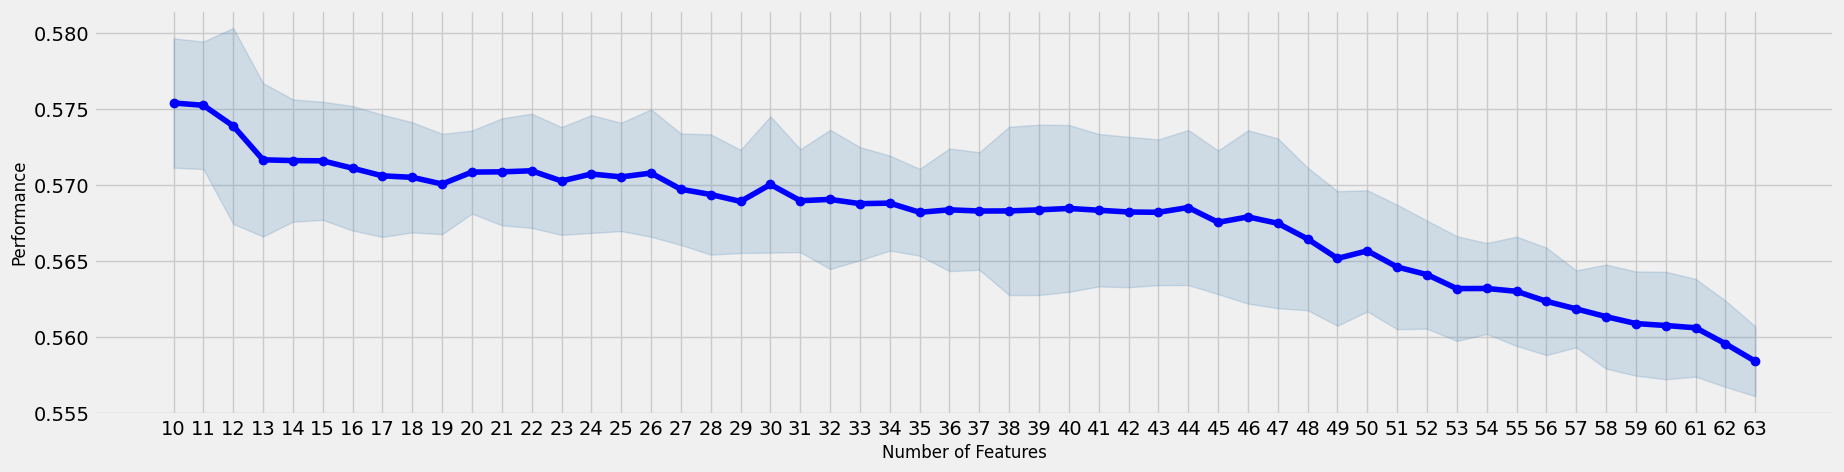

In [79]:
fig_sbs_std_dev = plot_sfs(sbs.get_metric_dict(), kind='std_dev', figsize=(20, 5))

# как видим, после 18 фичи качество начинает снижаться


#### 4.2 Отбор признаков при помощи метода Sequential Backward Selection

In [80]:
sfs = SequentialFeatureSelector(model,
                                k_features=FS_SFS_K_FEATURES,
                                forward=True,
                                floating=False,
                                scoring='r2',
                                cv=2,
                                n_jobs=-1)

In [81]:
sfs.fit(X_train, y_train)

/home/mle-user/.venv_impovement_model/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.
  warnings.warn(
/home/mle-user/.venv_impovement_model/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.
  warnings.warn(
/home/mle-user/.venv_impovement_model/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.
  warnings.warn(
/home/mle-user/.venv_impovement_model/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.
  warnings.warn(
/home/mle-user/.venv_impovem

SequentialFeatureSelector(cv=2,
                          estimator=DecisionTreeRegressor(max_depth=10,
                                                          random_state=42),
                          k_features=(10, 10), n_jobs=-1, scoring='r2')

In [82]:
# Посмотрим лучшие фичи по мнению sfs
selected_feature_sfs = sfs.k_feature_idx_
selected_feature_sfs

(12, 24, 29, 31, 37, 54, 56, 57, 58, 60)

In [83]:
# selected_feature_sfs = (3, 12, 25, 27, 39, 57, 59, 60, 62, 63)

In [84]:
X_train

,poly__kitchen_area,poly__living_area,poly__total_area,poly__ceiling_height,poly__kitchen_area^2,poly__kitchen_area living_area,poly__kitchen_area total_area,poly__kitchen_area ceiling_height,poly__living_area^2,poly__living_area total_area,poly__living_area ceiling_height,poly__total_area^2,poly__total_area ceiling_height,poly__ceiling_height^2,spline__kitchen_area_sp_0,spline__kitchen_area_sp_1,spline__kitchen_area_sp_2,spline__kitchen_area_sp_3,spline__kitchen_area_sp_4,spline__living_area_sp_0,spline__living_area_sp_1,spline__living_area_sp_2,spline__living_area_sp_3,spline__living_area_sp_4,spline__total_area_sp_0,spline__total_area_sp_1,spline__total_area_sp_2,spline__total_area_sp_3,spline__total_area_sp_4,spline__ceiling_height_sp_0,spline__ceiling_height_sp_1,spline__ceiling_height_sp_2,spline__ceiling_height_sp_3,spline__ceiling_height_sp_4,afc__kitchen_area,afc__living_area,afc__total_area,afc__house_age,afc__ceiling_height,afc__1/house_age,afc__house_age/total_area,afc__house_age*living_area,afc__house_age*kitchen_area,afc__living_area/total_area,afc__kitchen_area/total_area,afc__kitchen_area*total_area,afc__kitchen_area*living_area,afc__total_area*log(house_age),afc__sqrt(kitchen_area)/house_age,afc__sqrt(living_area)/total_area,afc__ceiling_height*log(total_area),afc__log(total_area)/ceiling_height,afc__log(ceiling_height)/ceiling_height,tail_scaler__flats_count,tail_scaler__floors_total,tail_scaler__floor,tail_scaler__distance_to_center,category_encoder__building_type_int,category_encoder__rooms,ohe__is_apartment_true,ohe__has_elevator_true,kbins__house_age,kbins__ceiling_height
0,-0.028034,-0.068882,-0.930621,0.101758,-0.223681,-0.145496,-0.543178,-0.022043,-0.320610,-0.474303,-0.061195,-0.863993,-0.874656,0.075891,-0.268016,-0.164538,0.684643,-0.299743,-0.304645,-0.402315,-0.062533,0.740643,-0.429341,-0.340570,0.560333,1.052722,-0.307854,-0.828483,-0.352981,-0.442524,-0.398238,0.820733,-0.139868,-0.343615,-0.028034,-0.068882,-0.930621,-0.193553,0.101758,-0.316083,0.183410,-0.185364,-0.071837,0.892331,0.753147,-0.543178,-0.145496,-0.759379,-0.275647,1.050528,-0.685807,-0.989699,0.700187,3.050830,1.941908,-1.264861,0.607362,4.0,1.0,0.0,1.0,1.0,2.0
1,0.278242,0.429745,0.204595,0.101758,0.117911,0.417608,0.233505,0.271998,0.223248,0.241486,0.429427,0.059624,0.198376,0.075891,-0.268016,-0.479638,0.591435,0.105328,-0.291641,-0.414458,-0.656127,0.858584,0.165143,-0.337384,-0.569639,-0.511290,1.093492,-0.046105,-0.352973,-0.442524,-0.398238,0.820733,-0.139868,-0.343615,0.278242,0.429745,0.204595,0.837399,0.101758,-0.568236,0.314745,0.936407,1.258137,0.427012,-0.026453,0.233504,0.417608,0.720428,-0.475034,0.210557,0.303504,0.245640,0.700187,-0.836794,0.184852,1.565224,0.270968,1.0,2.0,0.0,1.0,2.0,2.0
2,1.673499,0.664393,1.754471,2.433021,2.134454,1.599106,2.438808,2.084800,0.522708,1.130348,0.949744,1.869771,2.211088,2.482520,-0.268016,-1.156326,-1.411024,2.225920,1.925100,-0.414458,-0.858829,0.709747,0.529159,-0.287050,-0.569639,-1.404029,-1.421710,2.001618,1.469586,-0.452735,-1.815840,-2.033613,2.732966,2.948554,1.673499,0.664393,1.754471,-1.121410,2.433021,0.389947,-1.203464,-0.544012,-0.413181,-0.282915,0.038396,2.438808,1.599106,0.808115,0.683990,-0.550113,2.527008,-0.022924,-2.038609,-0.496272,0.380081,1.347525,-0.304829,2.0,2.0,0.0,1.0,0.0,4.0
3,-0.028034,0.224428,0.089034,-0.352385,-0.223681,0.069224,-0.030883,-0.078780,-0.015927,0.061178,0.180419,-0.049946,0.016616,-0.363370,-0.268016,-0.164538,0.684643,-0.299743,-0.304645,-0.414410,-0.437466,0.883265,-0.112410,-0.340570,-0.569041,-0.379638,1.083056,-0.165787,-0.352981,-0.268747,0.303144,0.371842,-0.460830,-0.343615,-0.028034,0.224428,0.089034,0.167280,-0.352385,-0.431018,-0.091172,0.255474,0.282148,0.255482,-0.210067,-0.030883,0.069224,0.356033,-0.376466,0.174998,-0.009738,0.429721,0.456268,-0.276352,-0.205605,1.129826,-0.195439,4.0,2.0,0.0,1.0,1.0,1.0
4,-0.028034,-0.582174,-0.862644,0.888937,-0.223681,-0.521256,-0.509025,0.076302,-0.749070,-0.689212,-0.51466

In [85]:
# Данные на лучших фичах по мнению sfs
X_train.iloc[:, list(selected_feature_sfs)]

,poly__total_area ceiling_height,spline__total_area_sp_0,spline__ceiling_height_sp_0,spline__ceiling_height_sp_2,afc__house_age,tail_scaler__floors_total,tail_scaler__distance_to_center,category_encoder__building_type_int,category_encoder__rooms,ohe__has_elevator_true
0,-0.874656,0.560333,-0.442524,0.820733,-0.193553,1.941908,0.607362,4.0,1.0,1.0
1,0.198376,-0.569639,-0.442524,0.820733,0.837399,0.184852,0.270968,1.0,2.0,1.0
2,2.211088,-0.569639,-0.452735,-2.033613,-1.121410,0.380081,-0.304829,2.0,2.0,1.0
3,0.016616,-0.569041,-0.268747,0.371842,0.167280,-0.205605,-0.195439,4.0,2.0,1.0
4,-0.718532,0.365085,-0.452735,0.638394,-1.430695,2.137136,-1.266700,2.0,1.0,1.0
...,...,...,...,...,...,...,...,...,...,...
72470,-1.051981,1.028754,-0.268747,0.371842,0.888947,-0.205605,-1.398214,6.0,1.0,1.0
72471,1.656928,-0.569639,-0.442524,0.820733,-0.863672,0.770537,1.033343,4.0,3.0,1.0
72472,0.604288,-0.569639,-0.452735,-2.033613,-1.121410,-1.181747,0.433402,2.0,2.0,1.0
72473,-0.423395,-0.419920,-0.268747,0.371842,0.682756,-0.791290,-1.076053,4.0,2.0,1.0


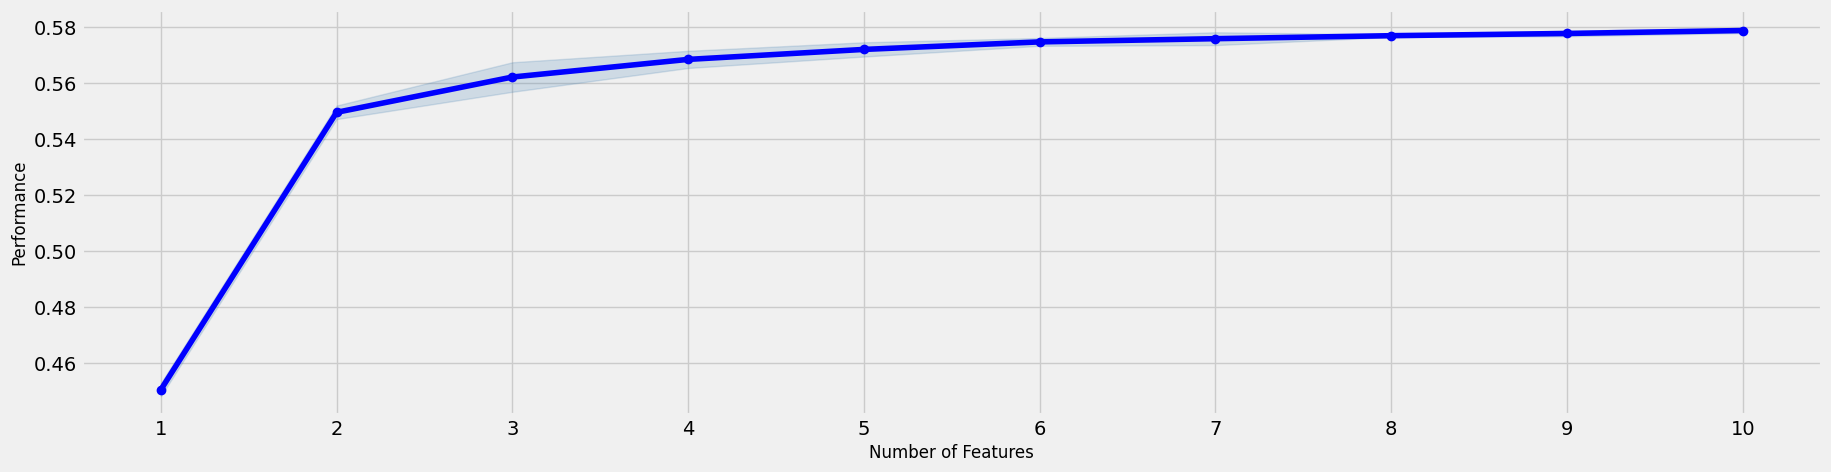

In [86]:
fig_sfs_std_dev = plot_sfs(sfs.get_metric_dict(), kind='std_dev', figsize=(20, 5))

#### 4.3 Анализ отобранных признаков при помощи двух методов и формирование финального списка с признаками для модели


In [87]:
# Используем объединение признаков
selected_features = list(set(selected_feature_sfs) | set(selected_feature_sbs))
selected_features

[2, 11, 12, 24, 25, 29, 31, 37, 52, 54, 56, 57, 58, 60]

In [88]:
# Данные на лучших фичах
X_train.iloc[:, selected_features]

,poly__total_area,poly__total_area^2,poly__total_area ceiling_height,spline__total_area_sp_0,spline__total_area_sp_1,spline__ceiling_height_sp_0,spline__ceiling_height_sp_2,afc__house_age,afc__log(ceiling_height)/ceiling_height,tail_scaler__floors_total,tail_scaler__distance_to_center,category_encoder__building_type_int,category_encoder__rooms,ohe__has_elevator_true
0,-0.930621,-0.863993,-0.874656,0.560333,1.052722,-0.442524,0.820733,-0.193553,0.700187,1.941908,0.607362,4.0,1.0,1.0
1,0.204595,0.059624,0.198376,-0.569639,-0.511290,-0.442524,0.820733,0.837399,0.700187,0.184852,0.270968,1.0,2.0,1.0
2,1.754471,1.869771,2.211088,-0.569639,-1.404029,-0.452735,-2.033613,-1.121410,-2.038609,0.380081,-0.304829,2.0,2.0,1.0
3,0.089034,-0.049946,0.016616,-0.569041,-0.379638,-0.268747,0.371842,0.167280,0.456268,-0.205605,-0.195439,4.0,2.0,1.0
4,-0.862644,-0.818260,-0.718532,0.365085,0.952937,-0.452735,0.638394,-1.430695,0.450285,2.137136,-1.266700,2.0,1.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
72470,-1.066575,-0.951800,-1.051981,1.028754,1.249102,-0.268747,0.371842,0.888947,0.456268,-0.205605,-1.398214,6.0,1.0,1.0
72471,1.747673,1.860448,1.656928,-0.569639,-1.402759,-0.442524,0.820733,-0.863672,0.700187,0.770537,1.033343,4.0,3.0,1.0
72472,0.224988,0.079326,0.604288,-0.569639,-0.533388,-0.452735,-2.033613,-1.121410,-2.038609,-1.181747,0.433402,2.0,2.0,1.0
72473,-0.386805,-0.463982,-0.423395,-0.419920,0.252292,-0.268747,0.371842,0.682756,0.456268,-0.791290,-1.076053,4.0,2.0,1.0


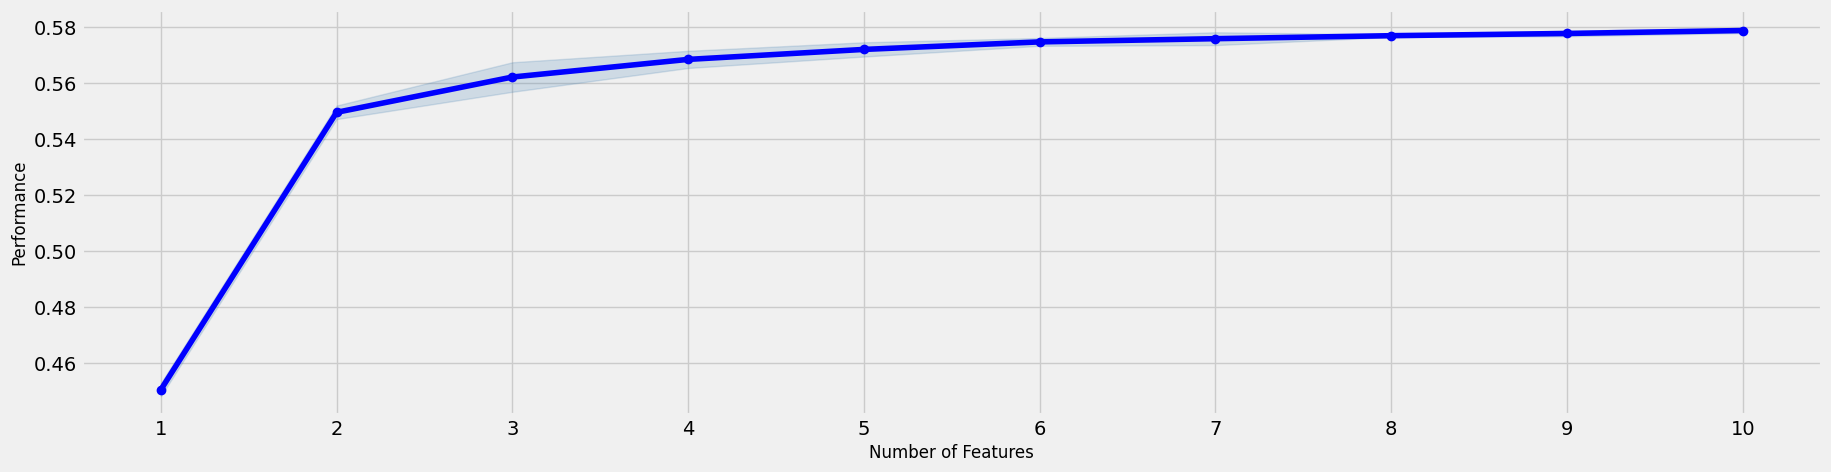

In [89]:
fig_sfs_std_dev[0]

In [90]:

# залогируем новый датасет

# Залогируем:
# новый датасет после feature selection, а также изображения с графиками для их отбора


with mlflow.start_run(run_name='RUN_ARTIFACT_FE_FS_dataset', experiment_id=experiment_id) as run:
    csv_path = os.path.join(DATA_DIR_PATH, 'datasets_with_FE_FS.csv')
    pd.concat([X_train.iloc[:, selected_features], y_train], axis=1).to_csv(csv_path, index=False)

    mlflow.log_artifact(csv_path)

    image_path_sfs = os.path.join(ARTIFACT_DIR, f"sfs_std_dev.png")
    # image_path_sbs = os.path.join(ARTIFACT_DIR, f"sbs_std_dev.png")
    fig_sfs_std_dev[0].savefig(image_path_sfs)
    # sbs пока убрал из логирования, нет времени по каждому перезауску ждать по часу...
    # fig_sbs_std_dev[0].savefig(image_path_sbs)
    mlflow.log_artifact(image_path_sfs)
    # mlflow.log_artifact(image_path_sbs)

#### 4.4 Обучение новой версии модели

In [91]:
# Теперь новый датасет выглядит так

(X_train, y_train) = X_train.iloc[:, selected_features], y_train

In [92]:
(X_test, y_test) = test_after_fe.iloc[:, selected_features], test_after_fe['price']

In [93]:
# Обучим на нем новую модель

In [94]:

model = DecisionTreeRegressor(max_depth=MODEL_MAX_DEPTH, random_state=RANDOM_STATE)
model.fit(X_train, y_train)

result_fs = evaluate_model(model, X_train, y_train,
                           X_test, y_test,
                           cv_strategy=KFold(n_splits=N_SPLITS))


result_fs

{'cv_neg_root_mean_squared_error': -0.226,
 'cv_r2': 0.581,
 'cv_neg_mean_absolute_error': -0.181,
 'fit_time': 0.57,
 'score_time': 0.008,
 'test_rmse': 0.223,
 'test_r2': 0.614,
 'test_mae': 0.179}

In [95]:
result_df = append_result_to_df(result_fs, "FS_model", result_df)

Сравнительная таблица после добавления модели FS_model


,cv_neg_root_mean_squared_error,cv_r2,cv_neg_mean_absolute_error,fit_time,score_time,test_rmse,test_r2,test_mae,model
0,-0.257,0.508,-0.199,0.779,0.022,0.252,0.335,0.194,baseline_model
1,-0.229,0.57,-0.182,3.9,0.018,0.226,0.605,0.181,FE_model
2,-0.226,0.581,-0.181,0.57,0.008,0.223,0.614,0.179,FS_model


In [96]:
result_df

,cv_neg_root_mean_squared_error,cv_r2,cv_neg_mean_absolute_error,fit_time,score_time,test_rmse,test_r2,test_mae,model
0,-0.257,0.508,-0.199,0.779,0.022,0.252,0.335,0.194,baseline_model
1,-0.229,0.57,-0.182,3.9,0.018,0.226,0.605,0.181,FE_model
2,-0.226,0.581,-0.181,0.57,0.008,0.223,0.614,0.179,FS_model


In [97]:
# Сохраним результаты cv и залогируем ее параметры


os.makedirs('cv_results', exist_ok=True)

# сохраняем локально словарь с метриками
path_result_cv = os.path.join(CV_RESULTS_PATH, "cv_res_FS.json")
with open(path_result_cv, 'w') as json_file:
    json.dump(result_fs, json_file)


#### 4.5 Логирование всех артефактов в MLflow

In [98]:

# Залогируем модель в mlflow
pip_requirements = "../requirements.txt"
signature = mlflow.models.infer_signature(X_train, y_train)
input_example = X_train[:10]
metadata = {"target_name": "price"}


with mlflow.start_run(run_name='model_with_FS_pipeline', experiment_id=experiment_id) as run:
    # сохранение модели
    model_info = mlflow.sklearn.log_model(
        sk_model=model,
        artifact_path="models",
        registered_model_name="model_with_fe_and_fs",
        signature=signature,
        pip_requirements=pip_requirements,
        input_example=input_example,
        metadata=metadata
)   
    # сохранение параметров
    mlflow.log_params(model.get_params())

    # сохранение метрик на cv + test
    mlflow.log_metrics({k: v for k, v in result_fs.items() if k != 'model'})

Registered model 'model_with_fe_and_fs' already exists. Creating a new version of this model...
2024/06/05 17:19:10 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: model_with_fe_and_fs, version 7
Created version '7' of model 'model_with_fe_and_fs'.


### Этап 5 - подбор гиперпараметров и обучение новой версии модели
После того как мы уделили значительное внимание качеству модели через создание и отбор признаков, пришло время для финального штриха — подбора гиперпараметров. Этот этап является ключевым. Задача — оптимизировать гиперпараметры модели для достижения наилучшего качества.


#### 5.1 Подбор гиперпарметров при мощи метода RandomSearh

In [99]:
params = {'max_depth': list(range(6, 25, 3)),
          'min_samples_leaf': [1, 2],
          'min_samples_split': [2, 3]}

In [100]:
cv_random_search = RandomizedSearchCV(estimator=model, param_distributions=params,
                                      n_iter=20, cv=2, scoring="r2", n_jobs=-1,
                                      random_state=RANDOM_STATE)

In [101]:
clf = cv_random_search.fit(X_train, y_train)

In [102]:
best_params_random_search = clf.best_params_

In [103]:
model_best_random_search = DecisionTreeRegressor(**best_params_random_search, random_state=42)

In [104]:
model_best_random_search.fit(X_train, y_train)

result_rs = evaluate_model(model_best_random_search, X_train, y_train,
                           X_test, y_test,
                           cv_strategy=KFold(n_splits=N_SPLITS))

In [105]:
result_df = append_result_to_df(result_rs, "params_random_search_model", result_df)

Сравнительная таблица после добавления модели params_random_search_model


,cv_neg_root_mean_squared_error,cv_r2,cv_neg_mean_absolute_error,fit_time,score_time,test_rmse,test_r2,test_mae,model
0,-0.257,0.508,-0.199,0.779,0.022,0.252,0.335,0.194,baseline_model
1,-0.229,0.57,-0.182,3.9,0.018,0.226,0.605,0.181,FE_model
2,-0.226,0.581,-0.181,0.57,0.008,0.223,0.614,0.179,FS_model
3,-0.227,0.578,-0.182,0.598,0.014,0.225,0.61,0.18,params_random_search_model


In [106]:
result_rs

{'cv_neg_root_mean_squared_error': -0.227,
 'cv_r2': 0.578,
 'cv_neg_mean_absolute_error': -0.182,
 'fit_time': 0.598,
 'score_time': 0.014,
 'test_rmse': 0.225,
 'test_r2': 0.61,
 'test_mae': 0.18,
 'model': 'params_random_search_model'}

In [107]:
# Залогируем параметры, модель и метрики


# Залогируем модель в mlflow
pip_requirements = "../requirements.txt"
signature = mlflow.models.infer_signature(X_train, y_train)
input_example = X_train[:10]
metadata = {"target_name": "price"}


with mlflow.start_run(run_name='model_with_random_search', experiment_id=experiment_id) as run:
    # сохранение модели
    model_info = mlflow.sklearn.log_model(
        sk_model=model_best_random_search,
        artifact_path="models",
        registered_model_name="model_with_random_search",
        signature=signature,
        pip_requirements=pip_requirements,
        input_example=input_example,
        metadata=metadata
)   
    # сохранение параметров
    mlflow.log_params(model_best_random_search.get_params())

    # сохранение метрик на cv + test
    mlflow.log_metrics({k: v for k, v in result_rs.items() if k != 'model'})

Registered model 'model_with_random_search' already exists. Creating a new version of this model...
2024/06/05 17:19:27 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: model_with_random_search, version 7
Created version '7' of model 'model_with_random_search'.


#### 5.2 Подбор гиперпарметров при помощи Optuna

In [108]:
# теперь подберем параметры с помощью optuna



def objective(trial: optuna.Trial) -> float:
    """
    Определяет целевую функцию для оптимизации гиперпараметров модели DecisionTreeRegressor с использованием Optuna.
    """
    params = {'max_depth': trial.suggest_int('max_depth', 5, 20),
            'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 4),
            'min_samples_split': trial.suggest_int('min_samples_split', 2, 4),
            'criterion': trial.suggest_categorical('criterion', ['friedman_mse', 'squared_error']),
            }

    model = DecisionTreeRegressor(**params, random_state=42)

    kf = KFold(n_splits=2, shuffle=True, random_state=42)

    r2_metrics = []

    for i, (train_index, val_index) in enumerate(kf.split(X_train, y_train)):
        train_x = X_train.iloc[train_index]
        train_y = y_train.iloc[train_index]
        val_x = X_train.iloc[val_index]
        val_y = y_train.iloc[val_index]

        model.fit(train_x, train_y)
        r2_metrics.append(r2_score(val_y, model.predict(val_x)))

    average_r2_skf = np.mean(r2_metrics)

    return average_r2_skf


with mlflow.start_run(run_name='optuna', experiment_id=experiment_id) as run:
    run_id = run.info.run_id

mlflclb = MLflowCallback(
    f"http://{TRACKING_SERVER_HOST}:{TRACKING_SERVER_PORT}",
    metric_name="r2",
    create_experiment=False,
    mlflow_kwargs = {
        "experiment_id": experiment_id, 
        "tags": {'mlflow.parentRunId': run_id}
    }
)
     
study = optuna.create_study(direction='maximize',
                           study_name='bulding_model_10',
                        #    storage=STUDY_DB_NAME,
                        #    load_if_exists=False,
                           sampler=optuna.samplers.TPESampler())

study.optimize(objective, n_trials=10, callbacks=[mlflclb], n_jobs=4)



[I 2024-06-05 17:19:27,944] A new study created in memory with name: bulding_model_10
[I 2024-06-05 17:19:28,712] Trial 2 finished with value: 0.5639931238709635 and parameters: {'max_depth': 7, 'min_samples_leaf': 4, 'min_samples_split': 3, 'criterion': 'friedman_mse'}. Best is trial 2 with value: 0.5639931238709635.
[I 2024-06-05 17:19:29,191] Trial 1 finished with value: 0.575380864310754 and parameters: {'max_depth': 11, 'min_samples_leaf': 3, 'min_samples_split': 4, 'criterion': 'squared_error'}. Best is trial 1 with value: 0.575380864310754.
[I 2024-06-05 17:19:29,539] Trial 0 finished with value: 0.5164567078180674 and parameters: {'max_depth': 16, 'min_samples_leaf': 1, 'min_samples_split': 4, 'criterion': 'squared_error'}. Best is trial 1 with value: 0.575380864310754.
[I 2024-06-05 17:19:29,701] Trial 3 finished with value: 0.5164456767949388 and parameters: {'max_depth': 16, 'min_samples_leaf': 1, 'min_samples_split': 4, 'criterion': 'friedman_mse'}. Best is trial 1 with val

In [109]:
best_params_optuna = study.best_params
best_params_optuna

{'max_depth': 10,
 'min_samples_leaf': 3,
 'min_samples_split': 4,
 'criterion': 'squared_error'}

In [110]:
model_best_optuna = DecisionTreeRegressor(**best_params_optuna, random_state=42)

model_best_optuna.fit(X_train, y_train)

result_optuna = evaluate_model(model_best_optuna, X_train, y_train,
                           X_test, y_test,
                           cv_strategy=KFold(n_splits=3))


result_df = append_result_to_df(result_optuna, "params_optuna_model", result_df)

Сравнительная таблица после добавления модели params_optuna_model


,cv_neg_root_mean_squared_error,cv_r2,cv_neg_mean_absolute_error,fit_time,score_time,test_rmse,test_r2,test_mae,model
0,-0.257,0.508,-0.199,0.779,0.022,0.252,0.335,0.194,baseline_model
1,-0.229,0.57,-0.182,3.9,0.018,0.226,0.605,0.181,FE_model
2,-0.226,0.581,-0.181,0.57,0.008,0.223,0.614,0.179,FS_model
3,-0.227,0.578,-0.182,0.598,0.014,0.225,0.61,0.18,params_random_search_model
4,-0.226,0.584,-0.18,0.464,0.007,0.223,0.616,0.179,params_optuna_model


In [111]:
# Залогируем параметры, модель и метрики


# Залогируем модель в mlflow
pip_requirements = "../requirements.txt"
signature = mlflow.models.infer_signature(X_train, y_train)
input_example = X_train[:10]
metadata = {"target_name": "price"}


with mlflow.start_run(run_name='model_with_optuna', experiment_id=experiment_id) as run:
    # сохранение модели
    model_info = mlflow.sklearn.log_model(
        sk_model=model_best_optuna,
        artifact_path="models",
        registered_model_name="model_with_optuna",
        signature=signature,
        pip_requirements=pip_requirements,
        input_example=input_example,
        metadata=metadata
)   
    # сохранение параметров
    mlflow.log_params(model_best_optuna.get_params())

    # сохранение метрик на cv + test
    mlflow.log_metrics({k: v for k, v in result_optuna.items() if k != 'model'})

Registered model 'model_with_optuna' already exists. Creating a new version of this model...
2024/06/05 17:19:36 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: model_with_optuna, version 3
Created version '3' of model 'model_with_optuna'.


### 6 Выводы

In [112]:
# Раскрасим таблицу в градации цвета по показателям r2 на cv

cm = sns.light_palette("green", as_cmap=True)

result_df['cv_r2'] = result_df['cv_r2'].astype('float')

result_df.sort_values(by=['cv_r2']).style.background_gradient(cmap=cm, subset=('cv_r2'))


# Как видим, наилучший показатель на cv на r2 были получены с помощью комплекса методов FE+FS+Optuna

,cv_neg_root_mean_squared_error,cv_r2,cv_neg_mean_absolute_error,fit_time,score_time,test_rmse,test_r2,test_mae,model
0,-0.257,0.508000,-0.199,0.779,0.022,0.252,0.335,0.194,baseline_model
1,-0.229000,0.570000,-0.182000,3.900000,0.018000,0.226000,0.605000,0.181000,FE_model
3,-0.227000,0.578000,-0.182000,0.598000,0.014000,0.225000,0.610000,0.180000,params_random_search_model
2,-0.226000,0.581000,-0.181000,0.570000,0.008000,0.223000,0.614000,0.179000,FS_model
4,-0.226000,0.584000,-0.180000,0.464000,0.007000,0.223000,0.616000,0.179000,params_optuna_model


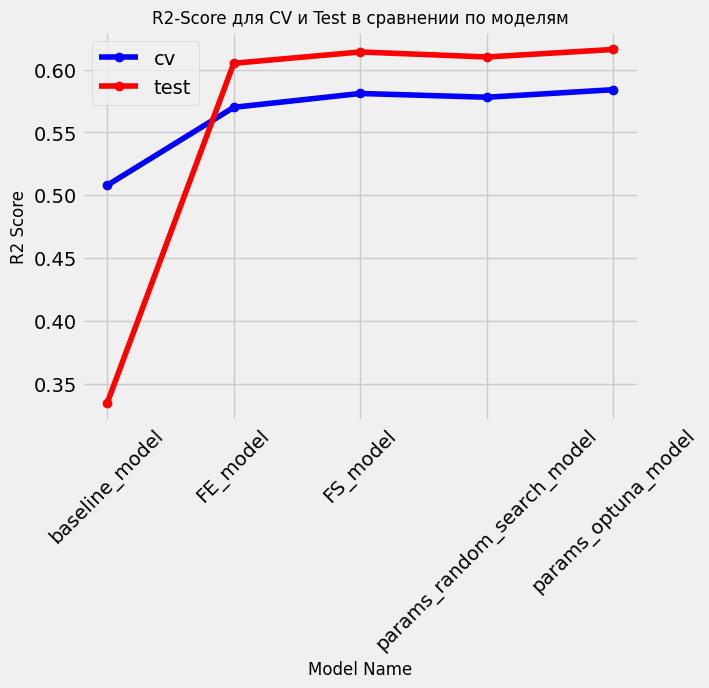

In [113]:
# Как видим, каждый этап постпенно улучшал изначальный baseline. Цель проекта по улучшению baseline достигнута. Метрика r2 увеличена с 0.5 до 0.584


plt.plot(result_df['model'], result_df['cv_r2'].astype('float'), marker='o', label='cv', color='blue')
plt.plot(result_df['model'], result_df['test_r2'].astype('float'), marker='o', label='test', color='red')
plt.title('R2-Score для CV и Test в сравнении по моделям')
plt.xlabel('Model Name')
plt.ylabel('R2 Score')
plt.legend()
# Повернем метки на оси X для удобства чтения
plt.xticks(rotation=45);

**Таким образом, по таблицу и графику выше мы видим, что каждый последующий этап действительно улучшает качество модели. В разработки моделей и жизненого цикла это очень важные этапы. Для улучшения результатов стоит провести анализ ошибок моделей:**

1. Рассмотреть остатки модели на:
* Нормальность (t-test для одной выборки)
* Тест на смещение остатков (Шапиро-Уилка)
* Проверка на гомоскедастичность (Barlets test / Levens test)

2. Проверить справедливость остатков (Residual Fairness) - размазанность ошибки по всем наблюдениям. Это можно сделать с помощью Gini Index - оценит степень отклонения остатков от абсолютного равенства.

3. Провести Best/Worse анализ - рассмотреть наблюдения, при которых остатки огромные и маленькие. Это поможет выделить паттерны ошибок

4. Запросить больше данных с сайта Недвижимости
